In [91]:
#List of imports

import pandas as pd
import scipy.optimize as sco
import numpy as np
import pandas_datareader as web
import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from hmmlearn import hmm

import statsmodels.api as smf
import urllib.request
import zipfile
import cvxpy as cp
from copy import deepcopy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import itertools

## Additions below
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler


In [105]:
from tqdm.notebook import tqdm
import warnings; warnings.simplefilter('ignore')

/Users/judymao/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# import pandas as pd
# import scipy.optimize as sco
# import numpy as np
# import pandas_datareader as web
# import datetime
# from scipy import stats
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.svm import LinearSVR
# from sklearn.pipeline import make_pipeline
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.preprocessing import StandardScaler
# import statsmodels.api as smf
# import urllib.request
# import zipfile

# from math import sqrt
# from pandas import read_csv
# from sklearn.metrics import mean_squared_error
# from matplotlib import pyplot as plt
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import LSTM
# from keras.layers import RepeatVector
# from keras.layers import TimeDistributed

In [69]:
def get_mu_Q_multiperiod(exRets, factor_data, lookahead, lookback, regress_type="Linear"):
    """
    exRets: excess return data for stocks
    factor_data: factor return data
    lookahead: number of periods in the future to estimate
    lookback: number of periods in the past to use for estimations
    regress_type: can be 'Linear', 'Lasso', or 'Ridge'
    """
    
    # For keeping track of mu's and Q's from each period
    mu_arr = []
    Q_arr = []
            
    n_factors = len(factor_data.columns)
    factor_data = factor_data.tail(lookback)
    exRets = exRets.tail(lookback)
    factor_data = deepcopy(factor_data)
    
    for i in range(0, lookahead):

        # Calculate the factor covariance matrix
        F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()
        
        # Calculate the factor expected excess return from historical data using the geometric mean
        factor_data.loc[:, 'Ones'] = 1
        gmean = stats.gmean(factor_data + 1,axis=0) - 1

        # Set up X and Y to determine alpha and beta
        X = factor_data
        Y = exRets
        X = X.to_numpy()
        Y = Y.to_numpy()

       # Determine alpha and beta
        if regress_type=="Linear":
            model = LinearRegression().fit(X,Y)
        elif regress_type=="Lasso":
            model = Lasso().fit(X,Y)
        elif regress_type=="Ridge":
            model = Ridge().fit(X,Y)
        else:
            print("Error: This type of regression has not been implemented.")
        alpha = model.intercept_
        beta = model.coef_[:,0:n_factors]

        # Calculate the residuals 
        alpha = np.reshape(alpha,(alpha.size,1))
        epsilon = exRets.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

        # Calculate the residual variance with "N - p - 1" degrees of freedom
        p = 3
        sigmaEp = np.sum(epsilon**2, axis=0) / (len(exRets) - 1 - p)

        #  Calculate the asset expected excess returns
        mu = model.predict([gmean])[0]

        # Calculate the diagonal matrix of residuals and the asset covariance matrix
        D = np.diag(sigmaEp)

        # Calculate the covariance matrix
        Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D
        
        # Add mu and Q to array
        mu_arr.append(mu)
        Q_arr.append(Q)
        
        # Update for next time step
        factor_data = factor_data[1:]
        factor_append = pd.Series(gmean, index = factor_data.columns)
        factor_data=factor_data.append(factor_append, ignore_index=True)
        
        exRets = exRets[1:]
        mu_append = pd.Series(mu, index=exRets.columns)
        exRets = exRets.append(mu_append, ignore_index=True)   
        
    return mu_arr, Q_arr

In [76]:
class Data:
    #Anything Data Related
    def __init__(self, stock_prices, universe, period='M'):
        
        if type(universe[0])== int:
            self.stock_prices=stock_prices.iloc[:,universe]

        else:
            self.stock_prices=stock_prices[universe]
        
        self.stock_prices.index= pd.to_datetime(self.stock_prices.index)

        self.factor_returns=None
        self.stock_returns=self.get_stock_returns(period)
        
        return
    
    def get_stock_returns(self, period='M'):
        price = self.stock_prices.resample(period).last()

        # Calculate the percent change
        ret_data = price.pct_change()[1:]

        # Convert from series to dataframe
        ret_data = pd.DataFrame(ret_data)
            
        return ret_data
    
    def set_factor_returns(self, factor_type='FF', period='M'):
        if factor_type == 'CAPM':
            self.factor_returns = self.get_CAPM_returns(period)
        
        elif factor_type == 'FF':
            self.factor_returns = self.get_FF_returns(period)
            
        elif factor_type == 'Carhart':
            self.factor_returns = self.get_Carhart_returns(period)
            
        elif factor_type == 'PCA':
            self.factor_returns = self.get_PCA_returns(period)
        
        else:
            print("Invalid input: Please select one of the following factor types: CAPM, FF, Carhart or PCA.")
        
        return   
    
    def get_FF_returns(self, period='M'):
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"    
        # Download the file and save it  
        urllib.request.urlretrieve(ff_url,'fama_french.zip')
        zip_file = zipfile.ZipFile('fama_french.zip', 'r')    
        # Extact the file data
        zip_file.extractall()
        zip_file.close()    
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)   
        # Skip null rows
        ff_row = ff_factors.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)

        # Format the date index
        ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')

        # Format dates to end of month
        ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

        # Resample the data to correct frequency
        ff_factors = ff_factors.resample(period).last()

        # Convert from percent to decimal
        ff_factors = ff_factors.apply(lambda x: x/ 100)

        return ff_factors
    
    def get_CAPM_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)
        
        # Remove the unnecessary factors
        capm_factors = ff_factors.iloc[:, 0]
        
        return capm_factors
    
    def get_Carhart_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)

        # Get the momentum factor
        momentum_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"

        # Download the file and save it  
        urllib.request.urlretrieve(momentum_url,'momentum.zip')
        zip_file = zipfile.ZipFile('momentum.zip', 'r')

        # Extact the file data
        zip_file.extractall()
        zip_file.close()

        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0)

        # Skip null rows
        row = momentum_factor.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, nrows = row, index_col = 0)

        # Format the date index
        momentum_factor.index = pd.to_datetime(momentum_factor.index, format= '%Y%m')

        # Format dates to end of month
        momentum_factor.index = momentum_factor.index + pd.offsets.MonthEnd()

         # Resample the data to correct frequency
        momentum_factor = momentum_factor.resample(period).last()

        # Convert from percent to decimal
        momentum_factor = momentum_factor.apply(lambda x: x/ 100)

        # Combine to create the carhart_factors
        carhart_factors = pd.concat([ff_factors, momentum_factor], axis=1).dropna()

        return carhart_factors
    
    def get_PCA_returns(self, period='M'):
        exRets = self.get_stock_returns(period="D")
        num_stocks = len(exRets.columns)
        returns_mat = exRets.to_numpy()
        n_dates = returns_mat.shape[0]
        n_assets = returns_mat.shape[1]
        
        demeaned = (returns_mat - returns_mat.mean(axis=0)).transpose()
        sigma = 1/(n_dates - 1)*np.matmul(demeaned,demeaned.transpose())
        eigval, eigvec = np.linalg.eig(sigma)
        
        principal_components = np.matmul(eigvec.transpose(),demeaned).transpose()
        pca_factors = np.real(principal_components[:,0:100])
        
        pca_df = pd.DataFrame(pca_factors, index = exRets.index, columns = [str(i) for i in range(num_stocks)])
        pca_df = pca_df.resample(period).last()
        
        return pca_df
    
    def get_index_from_date(self, date_index_df, date):

        return date_index_df.index.get_loc(date)
    
    def get_lookback_data(self, date_index_df, date, lookback):
        end_idx= self.get_index_from_date(date_index_df, date)
        return date_index_df.iloc[end_idx-lookback:end_idx]      
     



class Portfolio:
    #Anything Portfolio related: weights, returns, date-stamped
    def __init__(self, initial_weights):       
        num_assets=len(initial_weights)
        self.weights= np.array([initial_weights])
        self.returns= np.array([])
        self.dates= []
        return
        
    def update_weights(self, new_weights):
        
        new_weights=np.array([new_weights])        
        self.weights=np.append(self.weights,new_weights,axis=0)
        return
     
    
    def update_returns(self, new_returns):
        self.returns=np.append(self.returns, new_returns)
        return
        
    def update_dates(self, new_dates):
       
        self.dates.append(new_dates)
        return
        
    def get_Sharpe(self, risk_free):
        R_a = 0.001 # Dummy risk free rate
        sigma = np.std(self.returns - R_a)
        sharpe_ratio = (self.returns - R_a)/sigma
        return sharpe_ratio
        
    def plot(self):
        port_cumu_returns = np.array([x+1 for x in self.returns]).cumprod()
        plt.figure(figsize=(12,6))
        plt.plot(self.dates, port_cumu_returns)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
    

class Constraints:
        #List of all constraints
        def __init__(self, constr_list, upper_limit, lower_limit, stock_limit):
            self.upper_limit = upper_limit
            self.lower_limit = lower_limit
            self.stock_limit = stock_limit
            self.constr_list = constr_list
            self.value=[]

        
        def get_constraints(self, weights, y):
            if "weight_unity" in self.constr_list:
                
                self.value+= [cp.sum(weights,axis=0)==1]

            if "cardinality" in self.constr_list:
                self.value+= [cp.sum(y,axis=0)== self.stock_limit]        

            if "asset_limit_cardinality" in self.constr_list:
                print("HI")
                cardinality_upper_limit= cp.multiply(self.upper_limit, y)
                cardinality_lower_limit = cp.multiply(self.lower_limit,y)
                self.value+=  [weights>=cardinality_lower_limit, weights<=cardinality_upper_limit]

            if "no_short" in self.constr_list:
                self.value+=  [weights>=0]

            if "asset_limit" in self.constr_list:
                self.value+=[weights>=self.upper_limit, weights<=self.lower_limit]
        
            return

        

class Returns:
    def __init__(self):
        self.value=0
        return
    
    def get_returns(self,mu,weights):          
        portfolio_return_per_period= mu@weights
        portfolio_return= cp.trace(portfolio_return_per_period)
        self.value=portfolio_return
        return
    

class Risks:
    def __init__(self, risk_type="MVO", conf_lvl=0):
        self.value=0
        self.risk_type=risk_type
        self.conf_lvl=conf_lvl
        
    def get_risk(self,weights=None, Q=None, look_ahead=None, num_stocks=None):
        portfolio_risk=0
        robustness_cost=0
        for i in range(look_ahead):
            portfolio_risk+=cp.quad_form(weights[:,i],Q[i])        
        self.value=portfolio_risk
        
        if self.risk_type=="rect":
            for i in range(look_ahead):
                delta= stats.norm.ppf(self.conf_lvl)*np.sqrt(np.diag(Q[i]/num_stocks))
                robustness_cost+= delta@cp.abs(weights[:,i])
            self.value+= robustness_cost
        
        elif self.risk_type=="ellip":
            for i in range(look_ahead):
         
                penalty= cp.norm(np.sqrt(np.diag(Q[i]/num_stocks))@weights[:,i],2)
          
                robustness_cost+= stats.chi2.ppf(self.conf_lvl, num_stocks)*penalty
            self.value+= robustness_cost
            
        elif self.risk_type== "cvar":
            pass
        
        
        return
            
            
    

class Costs:
    def __init__(self, trans_coeff, holding_coeff):
        self.holding_cost= 0
        self.trans_cost= 0
        self.trans_coeff= trans_coeff
        self.holding_coeff= holding_coeff
        return
        
    def replicate_cost_coeff(self, num_stocks, look_ahead):
        trans_cost_repl= np.ones((num_stocks,look_ahead))/100
        holding_cost_repl= np.ones((num_stocks, look_ahead))/100
        self.trans_coeff= trans_cost_repl*self.trans_coeff
        self.holding_coeff= holding_cost_repl*self.holding_coeff
        return
    
    def get_holding_cost(self, weights_new):
        return cp.sum(cp.multiply(self.holding_coeff, cp.neg(weights_new)))
        
    def calc_trans_cost(self, weights_new, weights_old, trans_coeff):
        abs_trade= cp.abs(weights_new-weights_old)
        return cp.sum(cp.multiply(trans_coeff, abs_trade))       
    
    
    def get_trans_cost (self, weights_new,weights_old):
        
        weights_curr= weights_new[:,0]
        if weights_new.shape[1]>1:         
            weights_future= weights_new[:,1:]
            weights_future_shift= weights_new[:,:-1]
            self.trans_cost=self.calc_trans_cost(weights_future, weights_future_shift,self.trans_coeff[:,1:])        
        self.trans_cost+=self.calc_trans_cost( weights_curr, weights_old,self.trans_coeff[:,0])  
        return



class Model:
    def __init__(self, lam):
        self.opt_weights= 0
        self.status= None
        self.lam=lam
        
        return
        
    def Optim(self, port, mu , Q, look_ahead, constr_model, cost_model, risk_model, return_model):
        
        mu_np =np.array(mu)
        Q_np =np.array(Q)
        num_stocks=port.weights.shape[1]

        #Construct optimization problem
        weights=cp.Variable((num_stocks,look_ahead))
        y= cp.Variable((num_stocks,look_ahead), integer=True)
        
        weights_prev= port.weights[-1,:]

        cost_model.get_trans_cost(weights, weights_prev)
        cost_model.get_holding_cost(weights)

#         constraint_model.weight_unity(weights)
#         constraint_model.no_short(weights)
#         constraint_model.cardinality(y)
#         constraint_model.asset_limit_cardinality(y, weights)    
        
        constr_model.get_constraints(weights, y)

        
        return_model.get_returns(mu_np, weights)
        

        risk_model.get_risk(weights, Q,look_ahead,num_stocks)
        
    

        #objective= cp.Maximize(return_model.value - self.lam*risk_model.value - cost_model.trans_cost - cost_model.holding_cost)
        objective= cp.Maximize(return_model.value - self.lam*risk_model.value- cost_model.holding_cost-cost_model.trans_cost)
        print('objective', objective)
        #Construct Problem and Solve
        prob= cp.Problem(objective, constr_model.value)
        result=prob.solve(solver="GUROBI")
#         result=prob.solve()
        self.status= prob.status
    
        if self.status== "optimal":
            print("YAY")
            self.opt_weights=np.array(weights.value)[:,1]
        else:
            print("OH NO")
            self.opt_weights=weights_prev.T
     
        
        return self.opt_weights
        
        

    
class Backtest:
    def __init__(self,rebal_freq, start_date, end_date, lookback, lookahead):
        self.rebal_freq= rebal_freq
        self.start_date= start_date
        self.end_date= end_date
        self.lookback= lookback
        self.lookahead= lookahead
        self.reb_dates=None
        return
        
    
    def run(self, data, portfolio, factor_model, optimizer, constr_model, cost_model,risk_model,return_model):      
        stock_return= data.stock_returns
        factor_return= data.factor_returns        
        self.reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)    
 

        for t in self.reb_dates:
  
            returns_lookback= data.get_lookback_data(stock_return,t,self.lookback)
            factors_lookback= data.get_lookback_data(factor_return,t,self.lookback)

#             mu, Q = get_mu_Q_multiperiod(returns_lookback, factors_lookback, self.lookahead, self.lookback, "Lasso")
#             weights = MVO_Cardinality(mu,Q,self.lookahead,portfolio.weights[-1]) 
            mu, Q = factor_model.get_param_estimate(t, data)
    
            weights=optimizer.Optim(portfolio, mu , Q,self.lookahead, constr_model, cost_model, risk_model, return_model)     
            
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights,stock_return.loc[t]))
            

            ##How the lambdas influence
            
            
            
            

            
            
            ##When to use MVO.. when to use CVaR... implement a CVaR

        return
    
    # Judy additions below
    def run_v2(self, data, portfolio, optimizer, constr_model, cost, lookahead, lookback, model_type):      
        stock_return= data.stock_returns
        factor_return= data.factor_returns        
        self.reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)       

        factor = FactorModel(data, lookahead, lookback, model_type)
        
        for t in self.reb_dates:

            mu, Q = factor.get_param_estimate()

            weights=optimizer.MVO(port, mu , Q, constr_model, cost)     
            
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights,stock_return.loc[t]))

        
        return portfolio.get_Sharpe()

    
    def grid_search(self, price_data, universe, trans_coeff, hold_coeff, lam):

#         # Overall - currently test values are used in the Backtest2 class
#         rebalance_freqs = ['M', '3M', '6M', '12M', '60M'] # Period in Data class
#         pot_lookaheads = [1, 3, 6, 12, 60]
#         pot_lookbacks = [2, 3, 6, 12, 60]

#         # Factor Models
#         factor_models = ['CAPM', 'FF', 'Carhart', 'PCA'] # Data
#         regressions = ['linear', 'lasso', 'ridge', 'SVR'] # FactorModel

#         # Constraints
#         weight_unities = ['', 'weight_unity']
#         cardinalities = ['', 'cardinality']
#         asset_limits = ['asset_limit_cardinality', 'asset_limit']
#         no_shorts = ['', 'no_short']
#         constraints_list = [weight_unities, cardinalities, asset_limits, no_shorts]

#         stock_limits = list(range(5, 501, 5))

#         # Optimization
#         MVO_robustness = ['', 'rectangular', 'elliptical']

        # Overall
        rebal_freqs = ['M', '3M']
        pot_lookaheads = [5]
        pot_lookbacks = [20]

        # Factor Models
        factor_models = ['FF', 'PCA']  # Data
        regressions = ['Linear', 'Lasso', 'Ridge', 'SVR']  # FactorModel

        # Constraints
        weight_unities = ['weight_unity']
        cardinalities = ['cardinality']
        asset_limits = ['asset_limit_cardinality', 'asset_limit']
        no_shorts = ['no_short']
        constraints_list = [weight_unities, cardinalities, asset_limits, no_shorts]
        
        stock_limits = list(range(5, 21, 5))
        upper_asset_limits=[1]
        lower_asset_limits=[-1]

        # Optimization
        MVO_robustness = ['rectangular']
        
        # list of sharpe ratios per parameter combination
        sharpe_ratios = []

        # list of parameter combinations corresponding to sharpe ratio
        parameter_combos = []
        
        for combo in tqdm(list(itertools.product(rebal_freqs, factor_models, regressions,\
                                            list(itertools.product(*constraints_list)), stock_limits,\
                                            upper_asset_limits, lower_asset_limits,MVO_robustness))):
            
            # Store the combination
            curr_combo = {}
            curr_combo['rebalance_freq']=combo[0]
            curr_combo['factor_model']=combo[1]
            curr_combo['regression']=combo[2]
            curr_combo['constraints_list']=list(combo[3])
            curr_combo['stock_limit']=combo[4]
            curr_combo['upper_asset_limit']=combo[5]
            curr_combo['lower_asset_limit']=combo[6]
            curr_combo['robustness']=combo[7]
            
            # Initial Setup
            data_set = Data(price_data, universe, period=curr_combo['rebalance_freq'])
            data_set.set_factor_returns(curr_combo['factor_model'], curr_combo['rebalance_freq'])
            
            num_stocks=len(data_set.stock_returns.columns)
            cost_model= Costs(trans_coeff, hold_coeff)
            
            initial_weights= [1/num_stocks for i in range (num_stocks)]
            port = Portfolio(initial_weights)

            # Get lookaheads that are multiples of the rebalancing frequency and <= 60 months
            if curr_combo['rebalance_freq'] == 'M':
                first = 1
            else:
                first = int(curr_combo['rebalance_freq'][0])
            
            lookaheads = list(itertools.compress(pot_lookaheads, [look >= first for look in pot_lookaheads]))
            lookbacks = list(itertools.compress(pot_lookbacks, [look >= first for look in pot_lookbacks]))
            
            for lookahead in lookaheads:
                curr_combo['lookahead'] = lookahead
                for lookback in lookbacks:
                    curr_combo['lookback'] = lookback
#                     print(curr_combo)
                    
                    # Continue Setup
                    cost_model.replicate_cost_coeff(num_stocks, lookahead)
                    constr_model = Constraints(curr_combo['constraints_list'], curr_combo['upper_asset_limit'],\
                                               curr_combo['lower_asset_limit'], curr_combo['stock_limit'])
            
                    opt_model = Model(curr_combo['lookahead'], lam, curr_combo['robustness'])
                    
                    # Run backtest
                    sharpe = self.run_v2(data_set, port, opt_model, constr_model, cost_model, curr_combo['lookahead'],\
                                      curr_combo['lookback'], curr_combo['regression'])
                    
                    # Update results
                    sharpe_ratios.append(sharpe)
                    parameter_combos.append(curr_combo)

        return sharpe_ratios, parameter_combos


In [77]:
##Main

#Set up Data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
data_set= Data(price_data,[i for i in range(100)])
data_set.set_factor_returns()

#Set Up Portfolio
num_stocks=len(data_set.stock_returns.columns)
initial_weights= [1/num_stocks for i in range (num_stocks)]
port= Portfolio(initial_weights)


#Set Up model
rebal_freq="M"
start_date= "2014-10-31"
end_date= "2017-11-01"
lookback=20
lookahead=5
lam=0.9
trans_coeff=0.2
holding_coeff=0.2
conf_level=0.95


# upper_asset_limit=np.array([1/num_stocks for i in range(num_stocks)])
# upper_asset_limit=np.tile(upper_asset_limit, (look_ahead,1)).transpose()
# lower_asset_limit=np.array([-1/num_stocks for i in range(num_stocks)])
# lower_asset_limit=np.tile(lower_asset_limit, (look_ahead,1)).transpose()
upper_asset_limit=1
lower_asset_limit=-1
stock_limit=5

# Define constraints to use
constr_list = ["weight_unity", "no_short", "cardinality", "asset_limit_cardinality"]
constr_model = Constraints(constr_list, upper_asset_limit, lower_asset_limit, stock_limit)
cost_model= Costs(trans_coeff, holding_coeff)
cost_model.replicate_cost_coeff(num_stocks, lookahead)
opt_model=Model(lam)
risk_model=Risks("rect", conf_level)

regress_weighting = [0,0.5,0.5,0]
factor_model = FactorModel2(lookahead, lookback, regress_weighting)

back_test_ex= Backtest(rebal_freq, start_date, end_date, lookback, lookahead)
back_test_ex.run(data_set, port, factor_model, opt_model, constr_model, cost_model, risk_model, return_model)


HI
objective maximize trace([[ 0.0537468   0.02410744  0.03124202  0.02793027  0.01129183  0.00708651
   0.03255971  0.00742005  0.03091584  0.01735513  0.01994261  0.0256632
   0.00916956  0.00831109  0.01517536  0.00554601  0.01874743  0.00887673
   0.02724737  0.01110186  0.02457632 -0.00046634  0.02770904  0.03641916
   0.01755472  0.03272026  0.02869065  0.02118933  0.01168494  0.02634696
   0.01809958  0.03261926  0.01138139  0.01220351  0.00281274  0.03214967
   0.02195585  0.01780153  0.00742401  0.02185461  0.02015152  0.00184716
   0.03434801  0.00497838  0.04845841  0.00839431  0.0122091   0.02129532
   0.03127938  0.01687179  0.01316638  0.02263054  0.00345408  0.02913964
   0.04816015  0.01593983  0.0107591   0.04165311  0.01930114  0.01801794
   0.01868907  0.01949043  0.02592478  0.0193358   0.00541157  0.00225766
   0.02829319  0.00150996  0.02476262  0.01110493  0.00759874  0.00333412
   0.01160564  0.0201855   0.01210207  0.01065022  0.00188086  0.03607205
   0.006106

HI
objective maximize trace([[ 6.49940818e-02  2.92519635e-02  3.57162225e-02  3.11588140e-02
   1.38288701e-02  5.24568257e-03  3.12753951e-02  5.74086082e-03
   2.10688266e-02  2.16676376e-02  2.49342136e-02  3.23811659e-02
   1.23188862e-02  1.25248850e-02  1.11896517e-02  9.74676475e-03
   1.80931325e-02  1.08253147e-02  2.53919347e-02  1.16103976e-02
   2.96000220e-02 -3.98258283e-03  2.84907423e-02  4.16705998e-02
   1.79750528e-02  4.42773775e-02  2.67024624e-02  1.43611524e-02
   1.25917316e-02  3.05146748e-02  1.71582034e-02  3.20081965e-02
   1.24959187e-02  9.80213203e-03  3.22737897e-03  3.71412002e-02
   1.81025000e-02  2.25959868e-02  4.21089491e-03  2.41983618e-02
   1.83678784e-02  9.05548451e-03  1.96084356e-02  1.21627392e-02
   5.01942099e-02  7.81916659e-03  1.60088137e-02  1.98318645e-02
   4.09908374e-02  1.97607139e-02  1.53594600e-02  2.33505189e-02
   2.49553992e-03  2.61193830e-02  4.85177012e-02  2.00887796e-02
   1.00781145e-02  3.68959250e-02  1.93250454e-0

           0.0 <= var442835
result 0.18395477715698372
YAY
HI
objective maximize trace([[ 6.04981417e-02  3.41695794e-02  3.16244784e-02  2.99589093e-02
   1.26204419e-02  7.37475426e-03  2.84596160e-02  9.39550433e-03
   2.41772110e-02  2.10374093e-02  2.26423007e-02  3.18175852e-02
   1.14083185e-02  9.88170937e-03  6.39148260e-03  7.67487154e-03
   1.81757109e-02  1.11096609e-02  2.13342756e-02  8.19555357e-03
   3.53922951e-02 -1.45064940e-03  2.92660446e-02  3.50831853e-02
   1.72060227e-02  4.20897632e-02  3.19776840e-02  1.29776512e-02
   9.62206289e-03  2.54943841e-02  1.55996382e-02  3.05704361e-02
   1.67854895e-02  1.48136575e-02  2.67776687e-03  3.43660599e-02
   2.15403586e-02  2.17137265e-02 -6.22607333e-03  2.71516647e-02
   1.87089421e-02  1.09270312e-02  2.29252936e-02  1.30139872e-02
   5.18553638e-02  7.94118387e-03  1.31870097e-02  1.69333560e-02
   3.96542641e-02  1.97600876e-02  1.88125524e-02  1.87713594e-02
   8.06997676e-04  2.40835625e-02  3.87486975e-02  2.03

weights var443201
y var443202
objective maximize trace([[ 6.04981417e-02  3.41695794e-02  3.16244784e-02  2.99589093e-02
   1.26204419e-02  7.37475426e-03  2.84596160e-02  9.39550433e-03
   2.41772110e-02  2.10374093e-02  2.26423007e-02  3.18175852e-02
   1.14083185e-02  9.88170937e-03  6.39148260e-03  7.67487154e-03
   1.81757109e-02  1.11096609e-02  2.13342756e-02  8.19555357e-03
   3.53922951e-02 -1.45064940e-03  2.92660446e-02  3.50831853e-02
   1.72060227e-02  4.20897632e-02  3.19776840e-02  1.29776512e-02
   9.62206289e-03  2.54943841e-02  1.55996382e-02  3.05704361e-02
   1.67854895e-02  1.48136575e-02  2.67776687e-03  3.43660599e-02
   2.15403586e-02  2.17137265e-02 -6.22607333e-03  2.71516647e-02
   1.87089421e-02  1.09270312e-02  2.29252936e-02  1.30139872e-02
   5.18553638e-02  7.94118387e-03  1.31870097e-02  1.69333560e-02
   3.96542641e-02  1.97600876e-02  1.88125524e-02  1.87713594e-02
   8.06997676e-04  2.40835625e-02  3.87486975e-02  2.03208008e-02
   7.81838363e-03  2.

HI
objective maximize trace([[ 0.06595885  0.03056182  0.0350276   0.02687545  0.01092819  0.00550029
   0.02600234  0.0128896   0.02322064  0.01793605  0.02334481  0.02879749
   0.01315457  0.00975665  0.00089944  0.00648706  0.01593073  0.01024162
   0.01914504  0.00590849  0.02195465  0.00048805  0.0289782   0.03751532
   0.01855308  0.03637793  0.02996566  0.00553265  0.01431644  0.02284457
   0.01703684  0.03015517  0.00925676  0.01301608  0.00211177  0.02843975
   0.02374037  0.02274872 -0.00520835  0.0273826   0.01829406  0.01130706
   0.01812284  0.01130795  0.061217    0.01221523  0.01289173  0.01656461
   0.03772802  0.02179042  0.01733844  0.02073169  0.00291236  0.01921538
   0.02953464  0.02058912  0.00523164  0.02524277  0.01971439  0.01620892
   0.02266563  0.02198938  0.03182231  0.01903928  0.00881241  0.00302106
   0.0312477   0.00510855  0.02833816  0.01353183  0.00198296  0.01518614
   0.01703607  0.01618131  0.0208478   0.01140176  0.01293267  0.02700972
   0.00380

weights var443607
y var443608
objective maximize trace([[ 0.06595885  0.03056182  0.0350276   0.02687545  0.01092819  0.00550029
   0.02600234  0.0128896   0.02322064  0.01793605  0.02334481  0.02879749
   0.01315457  0.00975665  0.00089944  0.00648706  0.01593073  0.01024162
   0.01914504  0.00590849  0.02195465  0.00048805  0.0289782   0.03751532
   0.01855308  0.03637793  0.02996566  0.00553265  0.01431644  0.02284457
   0.01703684  0.03015517  0.00925676  0.01301608  0.00211177  0.02843975
   0.02374037  0.02274872 -0.00520835  0.0273826   0.01829406  0.01130706
   0.01812284  0.01130795  0.061217    0.01221523  0.01289173  0.01656461
   0.03772802  0.02179042  0.01733844  0.02073169  0.00291236  0.01921538
   0.02953464  0.02058912  0.00523164  0.02524277  0.01971439  0.01620892
   0.02266563  0.02198938  0.03182231  0.01903928  0.00881241  0.00302106
   0.0312477   0.00510855  0.02833816  0.01353183  0.00198296  0.01518614
   0.01703607  0.01618131  0.0208478   0.01140176  0.0129

HI
objective maximize trace([[ 5.97322102e-02  3.28480149e-02  3.63451478e-02  2.96241353e-02
   1.09773201e-02  2.13199269e-03  2.66399881e-02  7.61256107e-03
   2.05740002e-02  1.64071128e-02  2.04010052e-02  2.77340504e-02
   1.52804301e-02  1.69308573e-02  1.25729828e-03  2.05597076e-03
   5.88571354e-03  1.52555219e-02  1.32351967e-02  1.64456315e-03
   1.56248836e-02 -1.40125792e-02  2.24493263e-02  4.82102934e-02
   1.92600857e-02  3.61073351e-02  2.34129055e-02 -1.72598162e-02
   6.82468322e-03  2.24022145e-02  1.27809436e-02  2.27011606e-02
   1.19557364e-02  1.71032880e-02  5.23240268e-03  2.93594667e-02
   1.84685273e-02  2.34390277e-02 -1.08705648e-02  2.35771751e-02
   1.66250441e-02  1.91883207e-02  2.17544318e-02  1.43888535e-02
   5.33286121e-02  1.01181453e-02  1.78718416e-02  4.59084778e-03
   3.97872836e-02  2.00322836e-02  8.62798221e-03  7.58899936e-03
   5.49528670e-04  2.09742346e-02  2.16830052e-02  1.79100741e-02
   1.71413784e-03  2.83278215e-02  1.08205093e-0

weights var444053
y var444054
objective maximize trace([[ 5.97322102e-02  3.28480149e-02  3.63451478e-02  2.96241353e-02
   1.09773201e-02  2.13199269e-03  2.66399881e-02  7.61256107e-03
   2.05740002e-02  1.64071128e-02  2.04010052e-02  2.77340504e-02
   1.52804301e-02  1.69308573e-02  1.25729828e-03  2.05597076e-03
   5.88571354e-03  1.52555219e-02  1.32351967e-02  1.64456315e-03
   1.56248836e-02 -1.40125792e-02  2.24493263e-02  4.82102934e-02
   1.92600857e-02  3.61073351e-02  2.34129055e-02 -1.72598162e-02
   6.82468322e-03  2.24022145e-02  1.27809436e-02  2.27011606e-02
   1.19557364e-02  1.71032880e-02  5.23240268e-03  2.93594667e-02
   1.84685273e-02  2.34390277e-02 -1.08705648e-02  2.35771751e-02
   1.66250441e-02  1.91883207e-02  2.17544318e-02  1.43888535e-02
   5.33286121e-02  1.01181453e-02  1.78718416e-02  4.59084778e-03
   3.97872836e-02  2.00322836e-02  8.62798221e-03  7.58899936e-03
   5.49528670e-04  2.09742346e-02  2.16830052e-02  1.79100741e-02
   1.71413784e-03  2.

HI
objective maximize trace([[ 6.18033613e-02  4.35847522e-02  3.52802185e-02  3.20612797e-02
   1.63330107e-02  1.18824251e-02  2.99459402e-02  1.47279047e-02
   1.93075177e-02  2.01273999e-02  3.48925664e-02  2.48351470e-02
   1.15242423e-02  1.39032613e-02  5.18591365e-03  4.40169340e-03
   1.22237129e-02  1.28852134e-02  1.02956821e-02  4.51325420e-03
   2.92510213e-02 -1.94547819e-03  2.46970326e-02  4.93439309e-02
   1.99646118e-02  3.80608573e-02  2.91708236e-02 -7.75660085e-03
   1.32779952e-02  2.51250874e-02  1.54503649e-02  2.65705986e-02
   1.60849149e-02  1.91400728e-02  9.45623837e-03  3.04519726e-02
   2.36579282e-02  3.02096843e-02 -9.29309280e-03  2.86963820e-02
   1.91589524e-02  2.03925292e-02  2.81316637e-02  1.21971270e-02
   6.58144430e-02  1.21928006e-02  1.44225032e-02  5.77549276e-03
   4.23525725e-02  2.20434572e-02  1.74640012e-02  1.26951103e-02
   4.78244814e-04  2.11317479e-02  2.62004841e-02  2.09315759e-02
   1.00140759e-02  3.56457444e-02  1.85240709e-0

weights var444539
y var444540
objective maximize trace([[ 6.18033613e-02  4.35847522e-02  3.52802185e-02  3.20612797e-02
   1.63330107e-02  1.18824251e-02  2.99459402e-02  1.47279047e-02
   1.93075177e-02  2.01273999e-02  3.48925664e-02  2.48351470e-02
   1.15242423e-02  1.39032613e-02  5.18591365e-03  4.40169340e-03
   1.22237129e-02  1.28852134e-02  1.02956821e-02  4.51325420e-03
   2.92510213e-02 -1.94547819e-03  2.46970326e-02  4.93439309e-02
   1.99646118e-02  3.80608573e-02  2.91708236e-02 -7.75660085e-03
   1.32779952e-02  2.51250874e-02  1.54503649e-02  2.65705986e-02
   1.60849149e-02  1.91400728e-02  9.45623837e-03  3.04519726e-02
   2.36579282e-02  3.02096843e-02 -9.29309280e-03  2.86963820e-02
   1.91589524e-02  2.03925292e-02  2.81316637e-02  1.21971270e-02
   6.58144430e-02  1.21928006e-02  1.44225032e-02  5.77549276e-03
   4.23525725e-02  2.20434572e-02  1.74640012e-02  1.26951103e-02
   4.78244814e-04  2.11317479e-02  2.62004841e-02  2.09315759e-02
   1.00140759e-02  3.

HI
objective maximize trace([[ 0.05797683  0.03495638  0.03277595  0.03518484  0.01272732  0.01262999
   0.02479702  0.01374498  0.01503262  0.01598156  0.02839812  0.02339471
   0.00928805  0.01099558  0.00284733  0.00275367  0.01083006  0.01621253
   0.00721884  0.00346856  0.0248959  -0.00501726  0.01349584  0.0425157
   0.01739723  0.02312141  0.01951025 -0.01087117  0.00801031  0.02092092
   0.01006786  0.02050811  0.01519415  0.01384438  0.00613847  0.03089722
   0.01909857  0.0253516  -0.01134255  0.01782157  0.02094863  0.01938813
   0.01382644  0.01379302  0.06649924  0.00929224  0.01278456  0.00431117
   0.03813833  0.02217829  0.01437916  0.00460331 -0.0027122   0.01957845
   0.02074569  0.01739152  0.00377998  0.03650885  0.01387025  0.01434343
   0.02403655  0.0216563   0.02653883  0.01390861  0.01447891  0.00213214
   0.03053691 -0.0001003   0.00825813  0.01096211  0.00905713  0.01433482
   0.01268263  0.02196539  0.02008925  0.01556959  0.01158661  0.02393115
   0.004993

weights var445065
y var445066
objective maximize trace([[ 0.05797683  0.03495638  0.03277595  0.03518484  0.01272732  0.01262999
   0.02479702  0.01374498  0.01503262  0.01598156  0.02839812  0.02339471
   0.00928805  0.01099558  0.00284733  0.00275367  0.01083006  0.01621253
   0.00721884  0.00346856  0.0248959  -0.00501726  0.01349584  0.0425157
   0.01739723  0.02312141  0.01951025 -0.01087117  0.00801031  0.02092092
   0.01006786  0.02050811  0.01519415  0.01384438  0.00613847  0.03089722
   0.01909857  0.0253516  -0.01134255  0.01782157  0.02094863  0.01938813
   0.01382644  0.01379302  0.06649924  0.00929224  0.01278456  0.00431117
   0.03813833  0.02217829  0.01437916  0.00460331 -0.0027122   0.01957845
   0.02074569  0.01739152  0.00377998  0.03650885  0.01387025  0.01434343
   0.02403655  0.0216563   0.02653883  0.01390861  0.01447891  0.00213214
   0.03053691 -0.0001003   0.00825813  0.01096211  0.00905713  0.01433482
   0.01268263  0.02196539  0.02008925  0.01556959  0.01158

HI
objective maximize trace([[ 6.19676312e-02  3.14126968e-02  3.20086657e-02  3.66208742e-02
   1.73300857e-02  1.31321416e-02  2.78495959e-02  1.59641442e-02
   1.83221852e-02  1.59847445e-02  2.49334647e-02  2.40999249e-02
   1.05880859e-02  1.53769788e-02  3.31872778e-03  5.15011275e-03
   1.11555940e-02  1.72906117e-02  8.29391091e-03  8.04957001e-03
   2.81103292e-02  1.18465070e-03  1.75981608e-02  4.46338779e-02
   1.93383057e-02  2.55755455e-02  1.73853868e-02 -1.20745467e-02
   1.15272709e-02  2.00140642e-02  1.43826380e-02  1.99851024e-02
   1.63146583e-02  2.38812543e-02  2.21313424e-03  3.00160362e-02
   1.99860745e-02  2.31281364e-02 -8.03746879e-03  1.82192896e-02
   1.97041724e-02  2.14875596e-02  1.86419518e-02  1.51763093e-02
   6.00277070e-02  1.40277654e-02  1.53437342e-02  5.14361859e-03
   3.83568892e-02  2.46750204e-02  1.20274673e-02  8.00208677e-03
  -1.54231702e-04  1.78946348e-02  6.76942819e-03  1.95014806e-02
   6.79708052e-03  3.19593017e-02  1.91992506e-0

weights var445631
y var445632
objective maximize trace([[ 6.19676312e-02  3.14126968e-02  3.20086657e-02  3.66208742e-02
   1.73300857e-02  1.31321416e-02  2.78495959e-02  1.59641442e-02
   1.83221852e-02  1.59847445e-02  2.49334647e-02  2.40999249e-02
   1.05880859e-02  1.53769788e-02  3.31872778e-03  5.15011275e-03
   1.11555940e-02  1.72906117e-02  8.29391091e-03  8.04957001e-03
   2.81103292e-02  1.18465070e-03  1.75981608e-02  4.46338779e-02
   1.93383057e-02  2.55755455e-02  1.73853868e-02 -1.20745467e-02
   1.15272709e-02  2.00140642e-02  1.43826380e-02  1.99851024e-02
   1.63146583e-02  2.38812543e-02  2.21313424e-03  3.00160362e-02
   1.99860745e-02  2.31281364e-02 -8.03746879e-03  1.82192896e-02
   1.97041724e-02  2.14875596e-02  1.86419518e-02  1.51763093e-02
   6.00277070e-02  1.40277654e-02  1.53437342e-02  5.14361859e-03
   3.83568892e-02  2.46750204e-02  1.20274673e-02  8.00208677e-03
  -1.54231702e-04  1.78946348e-02  6.76942819e-03  1.95014806e-02
   6.79708052e-03  3.

HI
objective maximize trace([[ 0.04717613  0.0345363   0.03395256  0.03218836  0.01988813  0.01399981
   0.0230776   0.02008063  0.02006859  0.01570135  0.0165631   0.02019275
   0.00819812  0.01422462  0.00235833  0.00086668  0.01088143  0.01681103
   0.01086624  0.00590435  0.02357881  0.0011049   0.01393012  0.03978884
   0.01491503  0.02008609  0.00985161 -0.0198872   0.00919479  0.01812413
   0.01145054  0.01684896  0.01205619  0.01913143  0.00254189  0.03651937
   0.01650868  0.02523607 -0.01397958  0.01721191  0.02015891  0.01990974
   0.02288528  0.0145463   0.0674374   0.01882364  0.01316793  0.00409958
   0.03740192  0.0244143   0.00686867  0.01092414  0.00107778  0.01037812
   0.00475883  0.01801846  0.00141251  0.02853256  0.01964731  0.01619713
   0.02424498  0.01803076  0.02407447  0.01056094  0.01064388  0.01345919
   0.02747381  0.00298462  0.01418589  0.00738076  0.00646298  0.01902188
   0.01996739  0.01378532  0.02176355  0.01763215  0.00340661  0.01644168
   0.00423

weights var446237
y var446238
objective maximize trace([[ 0.04717613  0.0345363   0.03395256  0.03218836  0.01988813  0.01399981
   0.0230776   0.02008063  0.02006859  0.01570135  0.0165631   0.02019275
   0.00819812  0.01422462  0.00235833  0.00086668  0.01088143  0.01681103
   0.01086624  0.00590435  0.02357881  0.0011049   0.01393012  0.03978884
   0.01491503  0.02008609  0.00985161 -0.0198872   0.00919479  0.01812413
   0.01145054  0.01684896  0.01205619  0.01913143  0.00254189  0.03651937
   0.01650868  0.02523607 -0.01397958  0.01721191  0.02015891  0.01990974
   0.02288528  0.0145463   0.0674374   0.01882364  0.01316793  0.00409958
   0.03740192  0.0244143   0.00686867  0.01092414  0.00107778  0.01037812
   0.00475883  0.01801846  0.00141251  0.02853256  0.01964731  0.01619713
   0.02424498  0.01803076  0.02407447  0.01056094  0.01064388  0.01345919
   0.02747381  0.00298462  0.01418589  0.00738076  0.00646298  0.01902188
   0.01996739  0.01378532  0.02176355  0.01763215  0.0034

HI
objective maximize trace([[ 0.03637105  0.02785621  0.02595573  0.02596399  0.01532056  0.01448005
   0.02209663  0.01491597  0.01017854  0.01078348  0.01434721  0.01312085
   0.0031058   0.00725046 -0.0019012  -0.00156089  0.01051507  0.01542107
   0.00769167  0.0003651   0.02606147 -0.00553318  0.00629823  0.03320698
   0.01061284  0.02233011  0.00665008 -0.01108804  0.00817704  0.01536214
   0.006268    0.01179258  0.0088051   0.01147953  0.00326286  0.03470248
   0.01262489  0.01852183 -0.01797514  0.01268407  0.01908497  0.01555673
   0.02080682  0.01335768  0.05959741  0.01390445  0.0072323  -0.00131229
   0.03377746  0.02250081  0.00417845  0.01188393  0.00343295  0.00420622
  -0.00531863  0.01586974 -0.00370755  0.02869535  0.01537822  0.00791309
   0.01918623  0.0127912   0.02272721  0.00695139  0.00877701  0.01765429
   0.0186694   0.00271561  0.00953787  0.0041222   0.00364971  0.0192454
   0.02163717  0.01178958  0.02150613  0.01169488  0.00381534  0.01453856
   0.000775

weights var446883
y var446884
objective maximize trace([[ 0.03637105  0.02785621  0.02595573  0.02596399  0.01532056  0.01448005
   0.02209663  0.01491597  0.01017854  0.01078348  0.01434721  0.01312085
   0.0031058   0.00725046 -0.0019012  -0.00156089  0.01051507  0.01542107
   0.00769167  0.0003651   0.02606147 -0.00553318  0.00629823  0.03320698
   0.01061284  0.02233011  0.00665008 -0.01108804  0.00817704  0.01536214
   0.006268    0.01179258  0.0088051   0.01147953  0.00326286  0.03470248
   0.01262489  0.01852183 -0.01797514  0.01268407  0.01908497  0.01555673
   0.02080682  0.01335768  0.05959741  0.01390445  0.0072323  -0.00131229
   0.03377746  0.02250081  0.00417845  0.01188393  0.00343295  0.00420622
  -0.00531863  0.01586974 -0.00370755  0.02869535  0.01537822  0.00791309
   0.01918623  0.0127912   0.02272721  0.00695139  0.00877701  0.01765429
   0.0186694   0.00271561  0.00953787  0.0041222   0.00364971  0.0192454
   0.02163717  0.01178958  0.02150613  0.01169488  0.00381

HI
objective maximize trace([[ 0.03313458  0.02301778  0.0297168   0.02170701  0.01471765  0.01505044
   0.0203409   0.01144552  0.01014342  0.00717183  0.00814317  0.00912895
   0.00807407  0.01041416 -0.00533924 -0.00114294  0.01421452  0.02346018
   0.00784162  0.00146127  0.03104088 -0.00840461  0.00841051  0.03698345
   0.01261793  0.02631126  0.00337793 -0.02537163  0.00514468  0.02376367
   0.00310845  0.00825488  0.01077619  0.01917368  0.00587544  0.02693137
   0.0115598   0.01599055 -0.02970282  0.0148425   0.01480619  0.02047356
   0.02248184  0.01985278  0.05743637  0.01194177  0.01121157 -0.00482507
   0.03866536  0.02195802  0.0044831   0.00779008  0.00423318  0.00473454
  -0.00318092  0.01793116 -0.0086771   0.00857456  0.0140948   0.0061943
   0.01642464  0.01319972  0.02218003 -0.00128027  0.0116393   0.01618835
   0.01440199 -0.00167768  0.00972349  0.00376443  0.00582972  0.02108754
   0.02388979  0.01243087  0.01714103  0.01482331  0.01094753  0.0184095
   0.0034310

weights var447569
y var447570
objective maximize trace([[ 0.03313458  0.02301778  0.0297168   0.02170701  0.01471765  0.01505044
   0.0203409   0.01144552  0.01014342  0.00717183  0.00814317  0.00912895
   0.00807407  0.01041416 -0.00533924 -0.00114294  0.01421452  0.02346018
   0.00784162  0.00146127  0.03104088 -0.00840461  0.00841051  0.03698345
   0.01261793  0.02631126  0.00337793 -0.02537163  0.00514468  0.02376367
   0.00310845  0.00825488  0.01077619  0.01917368  0.00587544  0.02693137
   0.0115598   0.01599055 -0.02970282  0.0148425   0.01480619  0.02047356
   0.02248184  0.01985278  0.05743637  0.01194177  0.01121157 -0.00482507
   0.03866536  0.02195802  0.0044831   0.00779008  0.00423318  0.00473454
  -0.00318092  0.01793116 -0.0086771   0.00857456  0.0140948   0.0061943
   0.01642464  0.01319972  0.02218003 -0.00128027  0.0116393   0.01618835
   0.01440199 -0.00167768  0.00972349  0.00376443  0.00582972  0.02108754
   0.02388979  0.01243087  0.01714103  0.01482331  0.01094

HI
objective maximize trace([[ 2.79683404e-02  1.90507892e-02  2.52279814e-02  1.91621646e-02
   9.20624172e-03  7.69684008e-03  1.55238531e-02  6.51684716e-03
   3.66710953e-03  5.14784148e-03 -1.24658762e-03  1.61661763e-03
   6.67963955e-03  8.73839823e-03 -8.25966934e-03 -5.72280867e-03
   9.95871111e-03  1.79642674e-02  6.57269761e-03 -2.87008249e-03
   2.47682703e-02 -1.28298319e-02  1.25725773e-03  3.92058086e-02
   4.62963847e-03  1.65504332e-02 -1.38039022e-03 -3.16412932e-02
   2.36497076e-03  1.67369566e-02 -6.20627030e-03 -5.98558489e-05
   7.92248790e-03  1.63467409e-02  2.03379209e-03  2.29088526e-02
   6.54322044e-03  1.10935080e-02 -2.73460194e-02  1.24404962e-02
   8.75655249e-03  1.65641070e-02  2.61863115e-02  1.78791687e-02
   4.86564336e-02  8.34565364e-03  1.13462513e-02 -7.26478974e-03
   3.37823150e-02  2.12610724e-02 -4.56252892e-03  4.27245382e-03
   1.39577177e-03 -7.79272887e-04  4.53500496e-03  1.33972815e-02
  -1.62466168e-02  7.16391109e-03  8.10595365e-0

weights var448295
y var448296
objective maximize trace([[ 2.79683404e-02  1.90507892e-02  2.52279814e-02  1.91621646e-02
   9.20624172e-03  7.69684008e-03  1.55238531e-02  6.51684716e-03
   3.66710953e-03  5.14784148e-03 -1.24658762e-03  1.61661763e-03
   6.67963955e-03  8.73839823e-03 -8.25966934e-03 -5.72280867e-03
   9.95871111e-03  1.79642674e-02  6.57269761e-03 -2.87008249e-03
   2.47682703e-02 -1.28298319e-02  1.25725773e-03  3.92058086e-02
   4.62963847e-03  1.65504332e-02 -1.38039022e-03 -3.16412932e-02
   2.36497076e-03  1.67369566e-02 -6.20627030e-03 -5.98558489e-05
   7.92248790e-03  1.63467409e-02  2.03379209e-03  2.29088526e-02
   6.54322044e-03  1.10935080e-02 -2.73460194e-02  1.24404962e-02
   8.75655249e-03  1.65641070e-02  2.61863115e-02  1.78791687e-02
   4.86564336e-02  8.34565364e-03  1.13462513e-02 -7.26478974e-03
   3.37823150e-02  2.12610724e-02 -4.56252892e-03  4.27245382e-03
   1.39577177e-03 -7.79272887e-04  4.53500496e-03  1.33972815e-02
  -1.62466168e-02  7.

HI
objective maximize trace([[ 1.13377001e-02  2.33453939e-02  2.74368664e-02  1.88353471e-02
   5.78662081e-03  1.12367593e-02  1.84233126e-02  9.62105974e-03
   4.24898642e-03  9.71350097e-03 -4.96276710e-03  6.39042606e-03
   6.81394140e-03  8.89106132e-03 -1.59189323e-02 -3.11445134e-03
   1.00682325e-02  1.53624497e-02  1.04756881e-02 -4.91520363e-03
   2.26603528e-02 -1.46807762e-02 -5.96740131e-04  3.83870195e-02
   7.65777401e-03  2.23322987e-03 -3.29927223e-03 -2.84422533e-02
   4.05686640e-03  1.01672044e-02 -6.28312121e-03  2.45903275e-03
   4.97462043e-03  2.12776734e-02  6.74620446e-03  2.59952066e-02
   6.00282626e-03  1.78506779e-02 -3.07618377e-02  1.11279491e-02
   8.70908902e-03  1.06792797e-02  3.20972571e-02  1.86071813e-02
   4.66108289e-02  7.96208682e-03  1.40027253e-02 -5.80587897e-03
   2.07258455e-02  2.00173239e-02 -8.12896546e-03 -1.84348805e-03
  -4.98909866e-03  3.43854625e-03  2.55417807e-02  1.15051910e-02
  -1.53832172e-02  3.25014043e-04  1.15543295e-0

weights var449061
y var449062
objective maximize trace([[ 1.13377001e-02  2.33453939e-02  2.74368664e-02  1.88353471e-02
   5.78662081e-03  1.12367593e-02  1.84233126e-02  9.62105974e-03
   4.24898642e-03  9.71350097e-03 -4.96276710e-03  6.39042606e-03
   6.81394140e-03  8.89106132e-03 -1.59189323e-02 -3.11445134e-03
   1.00682325e-02  1.53624497e-02  1.04756881e-02 -4.91520363e-03
   2.26603528e-02 -1.46807762e-02 -5.96740131e-04  3.83870195e-02
   7.65777401e-03  2.23322987e-03 -3.29927223e-03 -2.84422533e-02
   4.05686640e-03  1.01672044e-02 -6.28312121e-03  2.45903275e-03
   4.97462043e-03  2.12776734e-02  6.74620446e-03  2.59952066e-02
   6.00282626e-03  1.78506779e-02 -3.07618377e-02  1.11279491e-02
   8.70908902e-03  1.06792797e-02  3.20972571e-02  1.86071813e-02
   4.66108289e-02  7.96208682e-03  1.40027253e-02 -5.80587897e-03
   2.07258455e-02  2.00173239e-02 -8.12896546e-03 -1.84348805e-03
  -4.98909866e-03  3.43854625e-03  2.55417807e-02  1.15051910e-02
  -1.53832172e-02  3.

HI
objective maximize trace([[ 0.01581369  0.02495354  0.02431927  0.01916628  0.0072234   0.01361247
   0.01436497  0.01026687  0.00790709  0.01306692  0.00634939  0.00430759
   0.00508589  0.00728275 -0.00853964  0.00068221  0.01367007  0.01486075
   0.01185563 -0.00191692  0.00259356 -0.00541521  0.0130288   0.03158783
   0.00779349  0.00280932 -0.00258329 -0.02089981  0.00258059  0.01521234
  -0.00076646  0.00372652  0.01270546  0.03193476  0.00763531  0.02302328
   0.00545975  0.02414195 -0.01998486  0.00790082  0.01125028  0.01201832
   0.03188078  0.01639581  0.03939903  0.01482566  0.01340604 -0.01007383
   0.02745901  0.01981996 -0.00208708  0.0026623   0.00104034  0.00851242
   0.01616514  0.01193687 -0.01188076 -0.00438121  0.01468295  0.00902567
   0.01175461  0.01143874  0.01856599 -0.01566722  0.00668672  0.01922131
   0.00779848 -0.01149208  0.01206282  0.00839929  0.00693962  0.01715876
   0.01944774  0.00584108  0.0037877   0.01257998  0.01624472  0.02299789
   0.01360

weights var449867
y var449868
objective maximize trace([[ 0.01581369  0.02495354  0.02431927  0.01916628  0.0072234   0.01361247
   0.01436497  0.01026687  0.00790709  0.01306692  0.00634939  0.00430759
   0.00508589  0.00728275 -0.00853964  0.00068221  0.01367007  0.01486075
   0.01185563 -0.00191692  0.00259356 -0.00541521  0.0130288   0.03158783
   0.00779349  0.00280932 -0.00258329 -0.02089981  0.00258059  0.01521234
  -0.00076646  0.00372652  0.01270546  0.03193476  0.00763531  0.02302328
   0.00545975  0.02414195 -0.01998486  0.00790082  0.01125028  0.01201832
   0.03188078  0.01639581  0.03939903  0.01482566  0.01340604 -0.01007383
   0.02745901  0.01981996 -0.00208708  0.0026623   0.00104034  0.00851242
   0.01616514  0.01193687 -0.01188076 -0.00438121  0.01468295  0.00902567
   0.01175461  0.01143874  0.01856599 -0.01566722  0.00668672  0.01922131
   0.00779848 -0.01149208  0.01206282  0.00839929  0.00693962  0.01715876
   0.01944774  0.00584108  0.0037877   0.01257998  0.0162

HI
objective maximize trace([[ 1.08953683e-02  2.34539118e-02  1.56623461e-02  2.19347892e-02
   8.95328911e-03  1.57991915e-02  1.80490058e-02  9.23987627e-03
  -5.56848803e-03  1.29816131e-02  1.69933606e-02  4.76841291e-03
   4.19986650e-03  6.25975225e-03 -1.52302706e-02  2.66190929e-03
   1.38412553e-02  1.29308299e-02  1.48126595e-02 -3.38772332e-03
   2.34282002e-03 -5.70352196e-03  1.45222975e-02  3.00199217e-02
   6.36650033e-03  1.04784772e-02 -4.71562114e-04 -1.92833746e-02
   5.71953981e-03  1.64089044e-02 -4.79740119e-03  2.18649072e-03
   1.10663344e-02  3.85943167e-02  1.04245961e-02  1.49272177e-02
   6.99678097e-03  2.97569343e-02 -2.01175994e-02  8.08840768e-03
   9.95347285e-03  1.32512118e-02  3.32353139e-02  1.74748342e-02
   4.01749085e-02  1.47342755e-02  1.31302180e-02 -1.04947202e-02
   3.32724595e-02  1.99034953e-02  4.17498988e-03  2.57223020e-03
  -1.54714738e-03  8.95786590e-03  1.19399846e-02  1.38408486e-02
  -1.13314083e-02  9.90386341e-05  1.21712865e-0

weights var450713
y var450714
objective maximize trace([[ 1.08953683e-02  2.34539118e-02  1.56623461e-02  2.19347892e-02
   8.95328911e-03  1.57991915e-02  1.80490058e-02  9.23987627e-03
  -5.56848803e-03  1.29816131e-02  1.69933606e-02  4.76841291e-03
   4.19986650e-03  6.25975225e-03 -1.52302706e-02  2.66190929e-03
   1.38412553e-02  1.29308299e-02  1.48126595e-02 -3.38772332e-03
   2.34282002e-03 -5.70352196e-03  1.45222975e-02  3.00199217e-02
   6.36650033e-03  1.04784772e-02 -4.71562114e-04 -1.92833746e-02
   5.71953981e-03  1.64089044e-02 -4.79740119e-03  2.18649072e-03
   1.10663344e-02  3.85943167e-02  1.04245961e-02  1.49272177e-02
   6.99678097e-03  2.97569343e-02 -2.01175994e-02  8.08840768e-03
   9.95347285e-03  1.32512118e-02  3.32353139e-02  1.74748342e-02
   4.01749085e-02  1.47342755e-02  1.31302180e-02 -1.04947202e-02
   3.32724595e-02  1.99034953e-02  4.17498988e-03  2.57223020e-03
  -1.54714738e-03  8.95786590e-03  1.19399846e-02  1.38408486e-02
  -1.13314083e-02  9.

HI
objective maximize trace([[ 1.43069003e-02  1.29701042e-02  1.39661920e-02  2.48178188e-02
   8.64323729e-03  1.42165276e-02  2.24857077e-02  5.86013538e-03
  -5.70031699e-03  1.16354109e-02  1.61709558e-02  8.58345978e-03
   3.46059601e-03  5.16830081e-03 -1.79283684e-02 -1.17802236e-03
   9.45464082e-03  1.44409609e-02  1.00141192e-02 -3.90947118e-03
   2.43511416e-03 -3.88300929e-03  1.52068293e-02  3.00964571e-02
   5.50533738e-03  1.19331370e-02  2.59244577e-03 -9.47323750e-03
   1.98260807e-03  2.14895138e-02 -9.26492835e-03 -1.41384608e-03
   8.83525037e-03  4.42211269e-02  1.05044582e-02  1.78347927e-02
   5.30494788e-03  2.69773714e-02 -2.72285067e-02  6.24965122e-03
   5.37250656e-03  1.14431822e-02  3.56814497e-02  1.61268879e-02
   4.65169370e-02  1.42156434e-02  1.47100036e-02 -1.05095723e-02
   3.69224970e-02  1.75311120e-02  5.84395201e-03  6.83976030e-03
  -3.46228466e-04  7.25515114e-03  1.07557262e-02  1.68487066e-02
  -1.57270362e-02  6.56271317e-03  1.11943636e-0

weights var451599
y var451600
objective maximize trace([[ 1.43069003e-02  1.29701042e-02  1.39661920e-02  2.48178188e-02
   8.64323729e-03  1.42165276e-02  2.24857077e-02  5.86013538e-03
  -5.70031699e-03  1.16354109e-02  1.61709558e-02  8.58345978e-03
   3.46059601e-03  5.16830081e-03 -1.79283684e-02 -1.17802236e-03
   9.45464082e-03  1.44409609e-02  1.00141192e-02 -3.90947118e-03
   2.43511416e-03 -3.88300929e-03  1.52068293e-02  3.00964571e-02
   5.50533738e-03  1.19331370e-02  2.59244577e-03 -9.47323750e-03
   1.98260807e-03  2.14895138e-02 -9.26492835e-03 -1.41384608e-03
   8.83525037e-03  4.42211269e-02  1.05044582e-02  1.78347927e-02
   5.30494788e-03  2.69773714e-02 -2.72285067e-02  6.24965122e-03
   5.37250656e-03  1.14431822e-02  3.56814497e-02  1.61268879e-02
   4.65169370e-02  1.42156434e-02  1.47100036e-02 -1.05095723e-02
   3.69224970e-02  1.75311120e-02  5.84395201e-03  6.83976030e-03
  -3.46228466e-04  7.25515114e-03  1.07557262e-02  1.68487066e-02
  -1.57270362e-02  6.

HI
objective maximize trace([[ 3.08019299e-03  5.56936537e-03  1.32898493e-02  1.18555643e-02
  -8.60495464e-04  1.39466243e-02  1.76131648e-02  3.47613034e-03
  -8.89812274e-03  9.56897084e-03  5.56986943e-05 -8.22893994e-03
   7.78781680e-03  7.91327872e-03 -1.70843304e-02 -1.61142369e-03
   4.13704278e-03  1.22866955e-02  1.01950728e-02 -8.84196785e-03
  -5.42480387e-03 -8.49822640e-03  1.12384199e-02  2.14867646e-02
   3.15395707e-03 -2.38753555e-03 -3.10638227e-03 -2.00517301e-02
  -4.46428361e-03  1.66325597e-02 -1.48502339e-02 -9.26622031e-03
   3.82990481e-03  3.62563978e-02  1.00465122e-02  1.08096007e-02
  -5.27289368e-05  1.97602498e-02 -3.30977778e-02  3.89915755e-03
   2.58811462e-03  3.71601482e-03  2.87294482e-02  1.07556792e-02
   3.69271959e-02  1.07051428e-02  1.56470916e-02 -2.43806909e-02
   2.98309345e-02  1.93779822e-02 -1.81743481e-03 -1.15644475e-03
  -3.49195054e-03 -3.62178246e-03  3.27980256e-03  1.19510007e-02
  -2.13939627e-02 -4.48882807e-03  4.10695202e-0

weights var452525
y var452526
objective maximize trace([[ 3.08019299e-03  5.56936537e-03  1.32898493e-02  1.18555643e-02
  -8.60495464e-04  1.39466243e-02  1.76131648e-02  3.47613034e-03
  -8.89812274e-03  9.56897084e-03  5.56986943e-05 -8.22893994e-03
   7.78781680e-03  7.91327872e-03 -1.70843304e-02 -1.61142369e-03
   4.13704278e-03  1.22866955e-02  1.01950728e-02 -8.84196785e-03
  -5.42480387e-03 -8.49822640e-03  1.12384199e-02  2.14867646e-02
   3.15395707e-03 -2.38753555e-03 -3.10638227e-03 -2.00517301e-02
  -4.46428361e-03  1.66325597e-02 -1.48502339e-02 -9.26622031e-03
   3.82990481e-03  3.62563978e-02  1.00465122e-02  1.08096007e-02
  -5.27289368e-05  1.97602498e-02 -3.30977778e-02  3.89915755e-03
   2.58811462e-03  3.71601482e-03  2.87294482e-02  1.07556792e-02
   3.69271959e-02  1.07051428e-02  1.56470916e-02 -2.43806909e-02
   2.98309345e-02  1.93779822e-02 -1.81743481e-03 -1.15644475e-03
  -3.49195054e-03 -3.62178246e-03  3.27980256e-03  1.19510007e-02
  -2.13939627e-02 -4.

HI
objective maximize trace([[ 2.17295059e-03  3.85300502e-03  7.77530074e-03  1.05695616e-02
  -7.96410007e-04  1.18196385e-02  9.32405601e-03  1.05610091e-03
  -8.52647117e-03  1.07827075e-02  1.48278091e-03 -1.05602209e-02
   8.10374460e-03  6.28542547e-03 -2.06453095e-02 -1.09807773e-03
  -1.89335488e-03  7.78841284e-03  5.58284147e-03 -6.74578613e-03
  -2.45471336e-03 -6.76623497e-03  9.84642123e-03  2.57036105e-02
   5.11905235e-03 -1.11828672e-03 -5.49268573e-03 -2.37888561e-02
  -4.39053752e-03  1.21860602e-02 -1.76255962e-02 -1.62414517e-02
   2.50064939e-03  3.13633354e-02  5.50268988e-03  1.12322214e-02
   4.11081603e-03  1.99374104e-02 -4.20720431e-02  2.56806290e-03
   5.83682229e-03  2.68537939e-03  2.05498876e-02  1.06760802e-02
   3.60340787e-02  1.36364134e-02  1.47137770e-02 -2.42772278e-02
   2.64863647e-02  1.94947150e-02 -2.65446295e-03 -7.64365604e-03
   1.90088890e-03 -1.46908491e-03  5.20981414e-03  1.24117176e-02
  -2.20578731e-02 -6.35062439e-03 -1.26187478e-0

weights var453491
y var453492
objective maximize trace([[ 2.17295059e-03  3.85300502e-03  7.77530074e-03  1.05695616e-02
  -7.96410007e-04  1.18196385e-02  9.32405601e-03  1.05610091e-03
  -8.52647117e-03  1.07827075e-02  1.48278091e-03 -1.05602209e-02
   8.10374460e-03  6.28542547e-03 -2.06453095e-02 -1.09807773e-03
  -1.89335488e-03  7.78841284e-03  5.58284147e-03 -6.74578613e-03
  -2.45471336e-03 -6.76623497e-03  9.84642123e-03  2.57036105e-02
   5.11905235e-03 -1.11828672e-03 -5.49268573e-03 -2.37888561e-02
  -4.39053752e-03  1.21860602e-02 -1.76255962e-02 -1.62414517e-02
   2.50064939e-03  3.13633354e-02  5.50268988e-03  1.12322214e-02
   4.11081603e-03  1.99374104e-02 -4.20720431e-02  2.56806290e-03
   5.83682229e-03  2.68537939e-03  2.05498876e-02  1.06760802e-02
   3.60340787e-02  1.36364134e-02  1.47137770e-02 -2.42772278e-02
   2.64863647e-02  1.94947150e-02 -2.65446295e-03 -7.64365604e-03
   1.90088890e-03 -1.46908491e-03  5.20981414e-03  1.24117176e-02
  -2.20578731e-02 -6.

HI
objective maximize trace([[ 6.96890555e-03  8.77220793e-03  1.69007888e-02  7.60344593e-03
   1.69637042e-03  2.03308700e-02  1.65496439e-02  1.10093478e-02
  -9.19495880e-03  1.24638621e-02  1.05140100e-02 -4.84286887e-03
   1.44297917e-02  1.34389485e-02 -7.42509602e-03  3.95687916e-03
   4.32020585e-03  1.19401059e-02  1.15061067e-02  7.76425045e-04
   6.96595459e-04  7.19147456e-03  1.65192752e-02  3.49368336e-02
   8.42735288e-03 -2.55776719e-03  4.14982199e-03 -3.86895332e-03
   2.88696770e-03  1.10606152e-02 -7.58653102e-03 -1.00880492e-02
   5.56069299e-03  3.68974703e-02  8.63973585e-03  1.33835197e-02
   1.20948393e-02  2.70528250e-02 -2.93415748e-02  5.64088711e-03
   1.03974790e-02  9.47171574e-03  2.37945280e-02  1.40084503e-02
   4.55595354e-02  2.29427783e-02  1.95822261e-02 -1.54241603e-02
   3.97715291e-02  2.27137296e-02  1.86427777e-03 -3.26330242e-03
   2.23256360e-03  4.88735155e-03  7.35131268e-03  1.47631567e-02
  -1.44084968e-02 -9.20382707e-03 -1.31149284e-0

weights var454497
y var454498
objective maximize trace([[ 6.96890555e-03  8.77220793e-03  1.69007888e-02  7.60344593e-03
   1.69637042e-03  2.03308700e-02  1.65496439e-02  1.10093478e-02
  -9.19495880e-03  1.24638621e-02  1.05140100e-02 -4.84286887e-03
   1.44297917e-02  1.34389485e-02 -7.42509602e-03  3.95687916e-03
   4.32020585e-03  1.19401059e-02  1.15061067e-02  7.76425045e-04
   6.96595459e-04  7.19147456e-03  1.65192752e-02  3.49368336e-02
   8.42735288e-03 -2.55776719e-03  4.14982199e-03 -3.86895332e-03
   2.88696770e-03  1.10606152e-02 -7.58653102e-03 -1.00880492e-02
   5.56069299e-03  3.68974703e-02  8.63973585e-03  1.33835197e-02
   1.20948393e-02  2.70528250e-02 -2.93415748e-02  5.64088711e-03
   1.03974790e-02  9.47171574e-03  2.37945280e-02  1.40084503e-02
   4.55595354e-02  2.29427783e-02  1.95822261e-02 -1.54241603e-02
   3.97715291e-02  2.27137296e-02  1.86427777e-03 -3.26330242e-03
   2.23256360e-03  4.88735155e-03  7.35131268e-03  1.47631567e-02
  -1.44084968e-02 -9.

HI
objective maximize trace([[-7.73509277e-04 -1.82992301e-03  9.25991301e-03  6.45442215e-03
  -1.94695800e-03  1.81345976e-02  1.48610995e-02  7.08502370e-03
  -7.92393597e-03  1.04224765e-02  1.15381570e-02 -9.08259337e-03
   1.03322559e-02  9.61137496e-03 -1.20860556e-02  7.31833956e-03
   2.03450775e-03  9.70490601e-03  1.36398770e-02  5.32781909e-05
  -4.60880969e-03  7.11086722e-03  1.59453816e-02  2.51785030e-02
   4.10647695e-03 -5.77354454e-03 -2.65270649e-03  5.08729589e-03
  -3.36623503e-03  9.14765281e-03 -8.13306631e-03 -1.16566869e-02
   4.55753987e-03  3.82917838e-02  6.53971178e-03  1.09742031e-02
   1.07569425e-02  2.51020914e-02 -2.32114664e-02  5.80268568e-03
   5.12207414e-03  1.03128581e-02  2.21346887e-02  8.45188451e-03
   3.35713848e-02  2.23156924e-02  1.93881430e-02 -1.30227107e-02
   3.79335214e-02  1.86310963e-02  2.25390369e-03 -2.17036507e-03
   5.86019288e-03  5.36149513e-03  3.16488331e-03  1.74723002e-02
  -1.87847376e-02 -7.67943159e-03  3.13857647e-0

weights var455543
y var455544
objective maximize trace([[-7.73509277e-04 -1.82992301e-03  9.25991301e-03  6.45442215e-03
  -1.94695800e-03  1.81345976e-02  1.48610995e-02  7.08502370e-03
  -7.92393597e-03  1.04224765e-02  1.15381570e-02 -9.08259337e-03
   1.03322559e-02  9.61137496e-03 -1.20860556e-02  7.31833956e-03
   2.03450775e-03  9.70490601e-03  1.36398770e-02  5.32781909e-05
  -4.60880969e-03  7.11086722e-03  1.59453816e-02  2.51785030e-02
   4.10647695e-03 -5.77354454e-03 -2.65270649e-03  5.08729589e-03
  -3.36623503e-03  9.14765281e-03 -8.13306631e-03 -1.16566869e-02
   4.55753987e-03  3.82917838e-02  6.53971178e-03  1.09742031e-02
   1.07569425e-02  2.51020914e-02 -2.32114664e-02  5.80268568e-03
   5.12207414e-03  1.03128581e-02  2.21346887e-02  8.45188451e-03
   3.35713848e-02  2.23156924e-02  1.93881430e-02 -1.30227107e-02
   3.79335214e-02  1.86310963e-02  2.25390369e-03 -2.17036507e-03
   5.86019288e-03  5.36149513e-03  3.16488331e-03  1.74723002e-02
  -1.87847376e-02 -7.

HI
objective maximize trace([[-4.06371507e-04  2.28834433e-03  1.07799494e-02  5.67260604e-04
  -2.38818157e-04  2.06533128e-02  1.95324407e-02  1.06154365e-02
  -5.62539658e-03  1.03231962e-02  8.88194081e-03 -1.34562141e-03
   1.40230722e-02  1.19676966e-02 -9.10489497e-03  1.01158166e-02
   5.69988965e-03  1.65132571e-02  1.71430924e-02  4.52062538e-03
  -5.75381493e-04  2.01180125e-02  2.30975315e-02  2.53402911e-02
   6.09501119e-03 -5.76924192e-04  1.02417169e-02  2.85687036e-02
  -1.06754587e-03  8.64989757e-03 -4.63770820e-03 -7.70190106e-03
   7.50774018e-03  4.55317388e-02  9.08359351e-03  6.58146540e-03
   1.24384647e-02  3.02262981e-02 -1.67838130e-02  5.82674570e-03
   9.23992021e-03  1.57972046e-02  3.49256317e-02  1.35875285e-02
   3.35342516e-02  2.71512959e-02  2.26611750e-02 -1.16478626e-02
   4.35313426e-02  2.11420321e-02  8.48413125e-03 -4.36445306e-03
   6.80309684e-03  1.92460954e-03  6.39053290e-04  2.05161560e-02
  -1.70812526e-02 -3.21617103e-03  5.97460391e-0

weights var456629
y var456630
objective maximize trace([[-4.06371507e-04  2.28834433e-03  1.07799494e-02  5.67260604e-04
  -2.38818157e-04  2.06533128e-02  1.95324407e-02  1.06154365e-02
  -5.62539658e-03  1.03231962e-02  8.88194081e-03 -1.34562141e-03
   1.40230722e-02  1.19676966e-02 -9.10489497e-03  1.01158166e-02
   5.69988965e-03  1.65132571e-02  1.71430924e-02  4.52062538e-03
  -5.75381493e-04  2.01180125e-02  2.30975315e-02  2.53402911e-02
   6.09501119e-03 -5.76924192e-04  1.02417169e-02  2.85687036e-02
  -1.06754587e-03  8.64989757e-03 -4.63770820e-03 -7.70190106e-03
   7.50774018e-03  4.55317388e-02  9.08359351e-03  6.58146540e-03
   1.24384647e-02  3.02262981e-02 -1.67838130e-02  5.82674570e-03
   9.23992021e-03  1.57972046e-02  3.49256317e-02  1.35875285e-02
   3.35342516e-02  2.71512959e-02  2.26611750e-02 -1.16478626e-02
   4.35313426e-02  2.11420321e-02  8.48413125e-03 -4.36445306e-03
   6.80309684e-03  1.92460954e-03  6.39053290e-04  2.05161560e-02
  -1.70812526e-02 -3.

HI
objective maximize trace([[-1.43176833e-02 -3.44173891e-03  6.92017920e-03 -1.78295475e-03
  -3.04612748e-03  1.83888702e-02  1.70105127e-02  8.89456432e-03
  -1.47432060e-03  6.55963391e-03  3.12475077e-03 -1.43202322e-02
   1.28598412e-02  1.02385863e-02 -2.44965822e-03  1.07894850e-02
   1.80575705e-03  1.20465133e-02  1.34774806e-02  1.18683371e-03
   2.43570123e-04  2.10751796e-02  2.32790294e-02  8.10776362e-03
   5.06757240e-03 -1.95884491e-02  8.21029378e-03  4.37477305e-02
  -4.66111671e-03 -9.16131451e-04 -1.39321846e-02 -1.46449525e-02
   9.14268314e-03  4.76674271e-02  8.10038304e-03  3.31678150e-03
   1.33724379e-02  2.73384109e-02 -9.19227666e-03  3.89618485e-03
   7.40572567e-03  1.29434891e-02  3.74161453e-02  8.45623849e-03
   3.43019859e-02  2.49368426e-02  2.43577530e-02 -1.68253332e-02
   3.21684732e-02  1.89156062e-02  8.30856433e-03 -9.82529227e-03
   1.03250062e-02  4.36849495e-03 -2.61961740e-03  1.49191920e-02
  -2.33242024e-02 -1.00136761e-02  2.17164325e-0

weights var457755
y var457756
objective maximize trace([[-1.43176833e-02 -3.44173891e-03  6.92017920e-03 -1.78295475e-03
  -3.04612748e-03  1.83888702e-02  1.70105127e-02  8.89456432e-03
  -1.47432060e-03  6.55963391e-03  3.12475077e-03 -1.43202322e-02
   1.28598412e-02  1.02385863e-02 -2.44965822e-03  1.07894850e-02
   1.80575705e-03  1.20465133e-02  1.34774806e-02  1.18683371e-03
   2.43570123e-04  2.10751796e-02  2.32790294e-02  8.10776362e-03
   5.06757240e-03 -1.95884491e-02  8.21029378e-03  4.37477305e-02
  -4.66111671e-03 -9.16131451e-04 -1.39321846e-02 -1.46449525e-02
   9.14268314e-03  4.76674271e-02  8.10038304e-03  3.31678150e-03
   1.33724379e-02  2.73384109e-02 -9.19227666e-03  3.89618485e-03
   7.40572567e-03  1.29434891e-02  3.74161453e-02  8.45623849e-03
   3.43019859e-02  2.49368426e-02  2.43577530e-02 -1.68253332e-02
   3.21684732e-02  1.89156062e-02  8.30856433e-03 -9.82529227e-03
   1.03250062e-02  4.36849495e-03 -2.61961740e-03  1.49191920e-02
  -2.33242024e-02 -1.

HI
objective maximize trace([[-1.03045563e-02 -4.00029454e-03  9.42465406e-03 -1.38562612e-03
   2.81559910e-03  1.49658280e-02  1.55522139e-02  1.01814489e-02
  -4.96458364e-03  2.61083917e-03  4.15127611e-03 -5.65707802e-03
   1.08871538e-02  1.03523920e-02 -2.26003921e-03  1.08724707e-02
   2.12231840e-03  1.20556773e-02  1.20281266e-02  2.59419860e-03
  -8.15661128e-03  2.35727518e-02  2.45490674e-02  1.03177097e-02
   1.36546057e-03 -1.54451848e-02  8.61173068e-03  6.06530470e-02
  -2.65552609e-03  4.64977804e-03 -1.27496116e-02 -1.35322708e-02
   6.24171494e-03  4.52534312e-02  4.17787078e-03  2.83516652e-03
   8.61065698e-03  2.95065658e-02 -3.54835858e-03  3.08833931e-03
   6.30006720e-03  1.54239242e-02  3.38243310e-02  8.32561817e-03
   3.22737603e-02  2.41978748e-02  2.35163313e-02 -1.51548182e-02
   3.55265272e-02  1.79982274e-02  8.49042810e-03 -4.88055206e-03
   1.13813111e-02  2.04433944e-03 -5.43706091e-03  1.22903039e-02
  -2.02244836e-02  2.01594199e-03  1.18743171e-0

weights var458921
y var458922
objective maximize trace([[-1.03045563e-02 -4.00029454e-03  9.42465406e-03 -1.38562612e-03
   2.81559910e-03  1.49658280e-02  1.55522139e-02  1.01814489e-02
  -4.96458364e-03  2.61083917e-03  4.15127611e-03 -5.65707802e-03
   1.08871538e-02  1.03523920e-02 -2.26003921e-03  1.08724707e-02
   2.12231840e-03  1.20556773e-02  1.20281266e-02  2.59419860e-03
  -8.15661128e-03  2.35727518e-02  2.45490674e-02  1.03177097e-02
   1.36546057e-03 -1.54451848e-02  8.61173068e-03  6.06530470e-02
  -2.65552609e-03  4.64977804e-03 -1.27496116e-02 -1.35322708e-02
   6.24171494e-03  4.52534312e-02  4.17787078e-03  2.83516652e-03
   8.61065698e-03  2.95065658e-02 -3.54835858e-03  3.08833931e-03
   6.30006720e-03  1.54239242e-02  3.38243310e-02  8.32561817e-03
   3.22737603e-02  2.41978748e-02  2.35163313e-02 -1.51548182e-02
   3.55265272e-02  1.79982274e-02  8.49042810e-03 -4.88055206e-03
   1.13813111e-02  2.04433944e-03 -5.43706091e-03  1.22903039e-02
  -2.02244836e-02  2.

HI
objective maximize trace([[-1.44319213e-02  5.00795353e-04  1.60434649e-03  1.47811286e-04
  -8.07055235e-04  1.42106165e-02  1.84906485e-02  8.38160549e-03
  -5.78320871e-03  4.41940618e-03  1.24013723e-02 -1.15249377e-02
   4.50558073e-03  4.18612756e-03 -3.03305401e-03  1.10483360e-02
   5.96831184e-03  1.13307927e-02  1.53456078e-02  3.72496527e-03
  -2.55602833e-03  2.01550436e-02  2.75219573e-02  9.93014839e-03
   2.85866451e-04 -1.39783996e-02  1.35541782e-02  6.67391436e-02
  -2.46545073e-03  5.89801950e-03 -1.64848686e-02 -1.09808905e-02
   8.14242681e-03  5.01121127e-02  8.29358911e-03  1.32791583e-03
   9.34429199e-03  2.91398183e-02 -5.10712585e-03  5.02381430e-03
   8.47587492e-03  1.27992645e-02  3.87946451e-02  4.65196393e-03
   3.28820928e-02  2.15158221e-02  1.80802164e-02 -1.46215217e-02
   3.72677047e-02  9.98270008e-03  9.42185897e-03 -1.68146198e-03
   9.83970294e-03  2.09952934e-03  2.36959799e-03  1.30509455e-02
  -1.84860761e-02 -4.37259025e-04  3.39341717e-0

weights var460127
y var460128
objective maximize trace([[-1.44319213e-02  5.00795353e-04  1.60434649e-03  1.47811286e-04
  -8.07055235e-04  1.42106165e-02  1.84906485e-02  8.38160549e-03
  -5.78320871e-03  4.41940618e-03  1.24013723e-02 -1.15249377e-02
   4.50558073e-03  4.18612756e-03 -3.03305401e-03  1.10483360e-02
   5.96831184e-03  1.13307927e-02  1.53456078e-02  3.72496527e-03
  -2.55602833e-03  2.01550436e-02  2.75219573e-02  9.93014839e-03
   2.85866451e-04 -1.39783996e-02  1.35541782e-02  6.67391436e-02
  -2.46545073e-03  5.89801950e-03 -1.64848686e-02 -1.09808905e-02
   8.14242681e-03  5.01121127e-02  8.29358911e-03  1.32791583e-03
   9.34429199e-03  2.91398183e-02 -5.10712585e-03  5.02381430e-03
   8.47587492e-03  1.27992645e-02  3.87946451e-02  4.65196393e-03
   3.28820928e-02  2.15158221e-02  1.80802164e-02 -1.46215217e-02
   3.72677047e-02  9.98270008e-03  9.42185897e-03 -1.68146198e-03
   9.83970294e-03  2.09952934e-03  2.36959799e-03  1.30509455e-02
  -1.84860761e-02 -4.

HI
objective maximize trace([[-0.00976148  0.00070428 -0.00093181 -0.00612342 -0.00019649  0.02028553
   0.02330408  0.01296463 -0.00243447  0.00402735  0.02109799 -0.00957899
   0.00518444  0.00218581  0.00582855  0.01277498  0.01193535  0.00849048
   0.02044963  0.00801816 -0.00048223  0.0334809   0.03053889  0.00190618
   0.00077313 -0.01481331  0.01824908  0.06530372  0.00103505  0.00715043
  -0.0139681  -0.00886394  0.00908229  0.04742356  0.00780124 -0.00227735
   0.01237782  0.02767791  0.00922892  0.0028493   0.01066359  0.00725168
   0.04047509  0.00252191  0.03063897  0.02136658  0.01598986 -0.00915645
   0.03185043  0.01356126  0.01341232  0.00446148  0.01280469 -0.00293755
   0.00683007  0.0141506  -0.01629111 -0.00655095  0.00688017  0.00521927
   0.01448475 -0.00249672  0.02569564 -0.01464494  0.00041434  0.01511299
  -0.00227675  0.00792185  0.00162157  0.00849251  0.0050277   0.00751022
   0.01878305 -0.00136907 -0.03788281  0.00918008  0.00108019  0.03144473
   0.02136

weights var461373
y var461374
objective maximize trace([[-0.00976148  0.00070428 -0.00093181 -0.00612342 -0.00019649  0.02028553
   0.02330408  0.01296463 -0.00243447  0.00402735  0.02109799 -0.00957899
   0.00518444  0.00218581  0.00582855  0.01277498  0.01193535  0.00849048
   0.02044963  0.00801816 -0.00048223  0.0334809   0.03053889  0.00190618
   0.00077313 -0.01481331  0.01824908  0.06530372  0.00103505  0.00715043
  -0.0139681  -0.00886394  0.00908229  0.04742356  0.00780124 -0.00227735
   0.01237782  0.02767791  0.00922892  0.0028493   0.01066359  0.00725168
   0.04047509  0.00252191  0.03063897  0.02136658  0.01598986 -0.00915645
   0.03185043  0.01356126  0.01341232  0.00446148  0.01280469 -0.00293755
   0.00683007  0.0141506  -0.01629111 -0.00655095  0.00688017  0.00521927
   0.01448475 -0.00249672  0.02569564 -0.01464494  0.00041434  0.01511299
  -0.00227675  0.00792185  0.00162157  0.00849251  0.0050277   0.00751022
   0.01878305 -0.00136907 -0.03788281  0.00918008  0.0010

HI
objective maximize trace([[-3.10843819e-03 -3.89891721e-03 -2.68336020e-03 -1.66527827e-02
  -6.71640248e-03  1.42895320e-02  1.64364822e-02  6.52563154e-03
  -2.11314994e-03 -4.40188124e-04  1.15970504e-02 -1.01366635e-02
   9.13585145e-03  6.83881344e-03 -1.44132680e-03  6.16058703e-03
   7.31755760e-03  9.22052783e-03  1.58535412e-02  2.54348256e-03
   5.31650475e-03  2.37402738e-02  2.23110596e-02  9.84384014e-03
  -7.31431168e-04 -1.07802928e-02  1.16383694e-02  5.71173320e-02
  -8.28414571e-03 -2.33041199e-03 -2.07787077e-02 -1.80433230e-02
   9.65718018e-03  4.09742367e-02  3.83732058e-03 -7.90916652e-03
   5.91752932e-03  2.03551642e-02  3.18010522e-03 -2.79806439e-03
   8.88261560e-03  7.63631989e-03  3.34115294e-02  1.99320828e-03
   1.79696342e-02  1.50000268e-02  1.72893101e-02 -7.85467683e-03
   2.12319004e-02  8.02914876e-03  3.79931109e-03  5.00089907e-03
   1.36192461e-02 -7.62778653e-04  3.66774909e-03  7.73456703e-03
  -2.12061512e-02 -1.44227770e-02  6.77198555e-0

weights var462659
y var462660
objective maximize trace([[-3.10843819e-03 -3.89891721e-03 -2.68336020e-03 -1.66527827e-02
  -6.71640248e-03  1.42895320e-02  1.64364822e-02  6.52563154e-03
  -2.11314994e-03 -4.40188124e-04  1.15970504e-02 -1.01366635e-02
   9.13585145e-03  6.83881344e-03 -1.44132680e-03  6.16058703e-03
   7.31755760e-03  9.22052783e-03  1.58535412e-02  2.54348256e-03
   5.31650475e-03  2.37402738e-02  2.23110596e-02  9.84384014e-03
  -7.31431168e-04 -1.07802928e-02  1.16383694e-02  5.71173320e-02
  -8.28414571e-03 -2.33041199e-03 -2.07787077e-02 -1.80433230e-02
   9.65718018e-03  4.09742367e-02  3.83732058e-03 -7.90916652e-03
   5.91752932e-03  2.03551642e-02  3.18010522e-03 -2.79806439e-03
   8.88261560e-03  7.63631989e-03  3.34115294e-02  1.99320828e-03
   1.79696342e-02  1.50000268e-02  1.72893101e-02 -7.85467683e-03
   2.12319004e-02  8.02914876e-03  3.79931109e-03  5.00089907e-03
   1.36192461e-02 -7.62778653e-04  3.66774909e-03  7.73456703e-03
  -2.12061512e-02 -1.

HI
objective maximize trace([[-0.00101583 -0.00365994  0.00958022 -0.0165123  -0.00710858  0.01362848
   0.01751434  0.0106195  -0.00200225  0.00650287  0.01618303 -0.00738176
   0.00855409  0.00353302 -0.00233767  0.00656754  0.00912503  0.00475836
   0.01935113  0.00499463  0.00221651  0.02956742  0.02956166  0.01481007
   0.0003515  -0.01184921  0.02196877  0.07564096 -0.00403827 -0.00197555
  -0.01458651 -0.00240541  0.00581264  0.03955308  0.00401181 -0.00215221
   0.00950402  0.02209647  0.01279756  0.00289206  0.00846078  0.00735088
   0.0270854  -0.00171433  0.01828246  0.01722293  0.01611082 -0.00150171
   0.02440012  0.00771976  0.00505143  0.02031839  0.01070888  0.002344
   0.01279319  0.00915573 -0.0105639  -0.01349145  0.01015817  0.00283222
   0.00433569 -0.00333773  0.00884735 -0.02013913 -0.00459273  0.0135969
  -0.0105672   0.0120736   0.01047961  0.00772844  0.00148375  0.00573872
   0.01900305 -0.01657572 -0.02478026  0.0021365   0.00292161  0.0195939
   0.01977793 

weights var463985
y var463986
objective maximize trace([[-0.00101583 -0.00365994  0.00958022 -0.0165123  -0.00710858  0.01362848
   0.01751434  0.0106195  -0.00200225  0.00650287  0.01618303 -0.00738176
   0.00855409  0.00353302 -0.00233767  0.00656754  0.00912503  0.00475836
   0.01935113  0.00499463  0.00221651  0.02956742  0.02956166  0.01481007
   0.0003515  -0.01184921  0.02196877  0.07564096 -0.00403827 -0.00197555
  -0.01458651 -0.00240541  0.00581264  0.03955308  0.00401181 -0.00215221
   0.00950402  0.02209647  0.01279756  0.00289206  0.00846078  0.00735088
   0.0270854  -0.00171433  0.01828246  0.01722293  0.01611082 -0.00150171
   0.02440012  0.00771976  0.00505143  0.02031839  0.01070888  0.002344
   0.01279319  0.00915573 -0.0105639  -0.01349145  0.01015817  0.00283222
   0.00433569 -0.00333773  0.00884735 -0.02013913 -0.00459273  0.0135969
  -0.0105672   0.0120736   0.01047961  0.00772844  0.00148375  0.00573872
   0.01900305 -0.01657572 -0.02478026  0.0021365   0.0029216

HI
objective maximize trace([[ 3.50691751e-03 -1.55192742e-03  1.16383075e-02 -1.66613092e-02
  -6.75914336e-03  1.32209507e-02  1.61489721e-02  1.04495126e-02
  -7.65225616e-04  1.06646267e-02  1.86906053e-02 -7.62178869e-03
   1.34463518e-02  6.29203216e-03 -3.15191127e-03  6.07873369e-03
   9.31910641e-03  1.08071050e-02  2.30857968e-02  5.43812795e-03
   2.80047331e-04  2.21079066e-02  2.65223316e-02  2.03374439e-02
   4.41530305e-03 -1.07728427e-02  2.82174155e-02  9.71122867e-02
  -2.60428129e-03 -6.26056151e-04 -1.81741727e-02 -1.71182100e-03
   7.27769495e-03  3.28309351e-02  4.52551934e-03 -5.90357942e-04
   8.32094171e-03  2.21213578e-02  4.22924579e-03  5.26529971e-03
   1.07053543e-02  1.09402799e-02  2.62050542e-02  4.97708747e-03
   2.41014670e-02  1.34139764e-02  1.57491133e-02  3.42795298e-04
   2.06741116e-02  8.83814820e-03  7.06418041e-03  2.08837575e-02
   1.05000773e-02  6.28958961e-03  1.36336275e-02  9.05365388e-03
  -1.03903532e-02 -9.55364982e-03  7.50653634e-0

weights var465351
y var465352
objective maximize trace([[ 3.50691751e-03 -1.55192742e-03  1.16383075e-02 -1.66613092e-02
  -6.75914336e-03  1.32209507e-02  1.61489721e-02  1.04495126e-02
  -7.65225616e-04  1.06646267e-02  1.86906053e-02 -7.62178869e-03
   1.34463518e-02  6.29203216e-03 -3.15191127e-03  6.07873369e-03
   9.31910641e-03  1.08071050e-02  2.30857968e-02  5.43812795e-03
   2.80047331e-04  2.21079066e-02  2.65223316e-02  2.03374439e-02
   4.41530305e-03 -1.07728427e-02  2.82174155e-02  9.71122867e-02
  -2.60428129e-03 -6.26056151e-04 -1.81741727e-02 -1.71182100e-03
   7.27769495e-03  3.28309351e-02  4.52551934e-03 -5.90357942e-04
   8.32094171e-03  2.21213578e-02  4.22924579e-03  5.26529971e-03
   1.07053543e-02  1.09402799e-02  2.62050542e-02  4.97708747e-03
   2.41014670e-02  1.34139764e-02  1.57491133e-02  3.42795298e-04
   2.06741116e-02  8.83814820e-03  7.06418041e-03  2.08837575e-02
   1.05000773e-02  6.28958961e-03  1.36336275e-02  9.05365388e-03
  -1.03903532e-02 -9.

HI
objective maximize trace([[ 7.02315355e-03 -1.21392341e-03  6.62183869e-03 -1.00868831e-02
  -4.73287172e-03  9.99971827e-03  1.92231248e-02  7.09855838e-03
  -6.34881542e-03  9.21989754e-03  2.60008094e-02 -7.76914935e-03
   1.44945794e-02  7.67571417e-03 -5.24722268e-03  7.00922446e-03
   6.45430546e-03  9.02382011e-03  2.18135770e-02  6.58954072e-03
   2.49212447e-05  2.55416896e-02  2.26575560e-02  2.27530879e-02
   6.83022866e-03 -5.77573188e-03  3.04262962e-02  9.23917927e-02
  -1.31025965e-03  3.47724032e-03 -1.51984669e-02 -8.37229954e-04
   7.16657192e-03  3.68564138e-02  3.10113359e-03 -2.58895268e-03
   6.25272146e-03  1.77468753e-02  7.61062944e-03  2.69272738e-03
   9.40400117e-03  1.06113208e-02  2.65365669e-02  3.23607355e-03
   1.71885109e-02  9.72338225e-03  1.80086647e-02  4.29686005e-04
   1.26986121e-02  4.66341167e-03  1.10243927e-02  2.03160941e-02
   1.60754833e-02  9.75922947e-03  1.57292117e-02  1.27275187e-02
  -9.55806090e-03 -1.37550951e-02  3.50502916e-0

weights var466757
y var466758
objective maximize trace([[ 7.02315355e-03 -1.21392341e-03  6.62183869e-03 -1.00868831e-02
  -4.73287172e-03  9.99971827e-03  1.92231248e-02  7.09855838e-03
  -6.34881542e-03  9.21989754e-03  2.60008094e-02 -7.76914935e-03
   1.44945794e-02  7.67571417e-03 -5.24722268e-03  7.00922446e-03
   6.45430546e-03  9.02382011e-03  2.18135770e-02  6.58954072e-03
   2.49212447e-05  2.55416896e-02  2.26575560e-02  2.27530879e-02
   6.83022866e-03 -5.77573188e-03  3.04262962e-02  9.23917927e-02
  -1.31025965e-03  3.47724032e-03 -1.51984669e-02 -8.37229954e-04
   7.16657192e-03  3.68564138e-02  3.10113359e-03 -2.58895268e-03
   6.25272146e-03  1.77468753e-02  7.61062944e-03  2.69272738e-03
   9.40400117e-03  1.06113208e-02  2.65365669e-02  3.23607355e-03
   1.71885109e-02  9.72338225e-03  1.80086647e-02  4.29686005e-04
   1.26986121e-02  4.66341167e-03  1.10243927e-02  2.03160941e-02
   1.60754833e-02  9.75922947e-03  1.57292117e-02  1.27275187e-02
  -9.55806090e-03 -1.

HI
objective maximize trace([[ 1.22750583e-02  7.09163846e-03  2.31798050e-03 -4.90049544e-03
  -1.26468336e-03  1.34037553e-02  2.01965771e-02  1.45361483e-02
   1.09314451e-03  1.31145151e-02  3.28081933e-02 -3.55106977e-03
   1.96014902e-02  1.28963135e-02 -3.64754365e-03  8.71120262e-03
   3.45096716e-03  1.31331209e-02  2.19029924e-02  1.06743973e-02
  -1.12829364e-04  3.43859166e-02  2.70127822e-02  2.50473076e-02
   1.32703646e-02 -1.07248907e-02  3.55628199e-02  1.09480347e-01
   5.49140658e-04  1.06884923e-02 -8.95783332e-03  7.59023768e-03
   1.23510967e-02  3.75994303e-02  9.08024461e-03  1.98056489e-03
   8.32227292e-03  1.89778473e-02  3.41431405e-03  6.33006686e-03
   9.87186892e-03  1.72836534e-02  3.47331209e-02  8.24781836e-03
   2.51661612e-02  1.57724700e-02  2.51234975e-02  4.09310154e-03
   1.26917821e-02  5.96020169e-03  1.65719355e-02  2.32453634e-02
   1.67244492e-02  1.55428025e-02  1.83031252e-02  1.39463195e-02
  -3.55971460e-03 -1.25818275e-02  7.80183562e-0

weights var468203
y var468204
objective maximize trace([[ 1.22750583e-02  7.09163846e-03  2.31798050e-03 -4.90049544e-03
  -1.26468336e-03  1.34037553e-02  2.01965771e-02  1.45361483e-02
   1.09314451e-03  1.31145151e-02  3.28081933e-02 -3.55106977e-03
   1.96014902e-02  1.28963135e-02 -3.64754365e-03  8.71120262e-03
   3.45096716e-03  1.31331209e-02  2.19029924e-02  1.06743973e-02
  -1.12829364e-04  3.43859166e-02  2.70127822e-02  2.50473076e-02
   1.32703646e-02 -1.07248907e-02  3.55628199e-02  1.09480347e-01
   5.49140658e-04  1.06884923e-02 -8.95783332e-03  7.59023768e-03
   1.23510967e-02  3.75994303e-02  9.08024461e-03  1.98056489e-03
   8.32227292e-03  1.89778473e-02  3.41431405e-03  6.33006686e-03
   9.87186892e-03  1.72836534e-02  3.47331209e-02  8.24781836e-03
   2.51661612e-02  1.57724700e-02  2.51234975e-02  4.09310154e-03
   1.26917821e-02  5.96020169e-03  1.65719355e-02  2.32453634e-02
   1.67244492e-02  1.55428025e-02  1.83031252e-02  1.39463195e-02
  -3.55971460e-03 -1.

HI
objective maximize trace([[ 7.69546644e-03  1.11732765e-02 -5.03253609e-03 -6.26768230e-03
  -3.64860448e-03  9.06307938e-03  2.45736959e-02  1.91145633e-02
   9.32648690e-04  1.32894270e-02  3.24077685e-02  5.83336402e-04
   1.49971094e-02  9.61646482e-03 -3.38844012e-03  7.27222694e-03
   4.24697825e-04  7.87839649e-03  1.45481130e-02  1.01771559e-02
  -7.36500526e-03  3.73888222e-02  3.28364362e-02  1.33977401e-02
   9.71699059e-03 -1.91511040e-02  4.41034951e-02  1.19586982e-01
   2.23079374e-03 -3.56822917e-04 -7.69763522e-03  6.60248946e-03
   1.43157576e-02  2.82965953e-02  7.53666633e-03  5.15805575e-03
   9.09003092e-03  1.98836901e-02  1.24882637e-02  2.41014469e-03
   1.26341277e-02  1.05973974e-02  3.67101624e-02  4.29770316e-03
   3.00009475e-02  1.57783176e-02  2.16026324e-02  4.56827770e-03
   5.07064440e-03  2.49095516e-03  1.50301631e-02  1.85103860e-02
   1.48888623e-02  1.26429437e-02  2.44830492e-02  1.03456402e-02
  -1.05519837e-03 -4.66796839e-03  6.19356833e-0

weights var469689
y var469690
objective maximize trace([[ 7.69546644e-03  1.11732765e-02 -5.03253609e-03 -6.26768230e-03
  -3.64860448e-03  9.06307938e-03  2.45736959e-02  1.91145633e-02
   9.32648690e-04  1.32894270e-02  3.24077685e-02  5.83336402e-04
   1.49971094e-02  9.61646482e-03 -3.38844012e-03  7.27222694e-03
   4.24697825e-04  7.87839649e-03  1.45481130e-02  1.01771559e-02
  -7.36500526e-03  3.73888222e-02  3.28364362e-02  1.33977401e-02
   9.71699059e-03 -1.91511040e-02  4.41034951e-02  1.19586982e-01
   2.23079374e-03 -3.56822917e-04 -7.69763522e-03  6.60248946e-03
   1.43157576e-02  2.82965953e-02  7.53666633e-03  5.15805575e-03
   9.09003092e-03  1.98836901e-02  1.24882637e-02  2.41014469e-03
   1.26341277e-02  1.05973974e-02  3.67101624e-02  4.29770316e-03
   3.00009475e-02  1.57783176e-02  2.16026324e-02  4.56827770e-03
   5.07064440e-03  2.49095516e-03  1.50301631e-02  1.85103860e-02
   1.48888623e-02  1.26429437e-02  2.44830492e-02  1.03456402e-02
  -1.05519837e-03 -4.

HI
objective maximize trace([[ 9.47254921e-03  1.46930074e-02 -7.39421667e-03 -7.21007204e-03
   8.14810781e-04  1.39447052e-02  2.80482552e-02  1.77259788e-02
   3.18186798e-03  1.58520836e-02  3.82800905e-02  3.95875540e-03
   1.60508015e-02  1.21535896e-02  3.20774956e-04  1.32278332e-02
   2.15724768e-03  1.10951827e-02  1.50146389e-02  1.34455810e-02
  -2.80619396e-03  4.72352018e-02  4.63835535e-02  1.01206524e-02
   1.73352185e-02 -1.00557629e-02  4.99631462e-02  1.18406837e-01
   4.39130060e-03  6.44379671e-03 -2.02895111e-03  1.10737511e-02
   1.76628781e-02  3.26373910e-02  1.20256486e-02  1.32276463e-02
   1.32137684e-02  2.76350913e-02  1.04912817e-02  5.38310707e-03
   1.70272492e-02  1.51249765e-02  3.36005596e-02  8.11069010e-03
   3.00929005e-02  1.96762992e-02  2.28532992e-02  4.22458351e-03
  -1.94339294e-04 -7.16526546e-04  2.27611415e-02  2.22909868e-02
   2.06076105e-02  1.95782072e-02  2.02971040e-02  1.49677650e-02
   5.55532872e-03 -1.70078308e-03  1.01637368e-0

weights var471215
y var471216
objective maximize trace([[ 9.47254921e-03  1.46930074e-02 -7.39421667e-03 -7.21007204e-03
   8.14810781e-04  1.39447052e-02  2.80482552e-02  1.77259788e-02
   3.18186798e-03  1.58520836e-02  3.82800905e-02  3.95875540e-03
   1.60508015e-02  1.21535896e-02  3.20774956e-04  1.32278332e-02
   2.15724768e-03  1.10951827e-02  1.50146389e-02  1.34455810e-02
  -2.80619396e-03  4.72352018e-02  4.63835535e-02  1.01206524e-02
   1.73352185e-02 -1.00557629e-02  4.99631462e-02  1.18406837e-01
   4.39130060e-03  6.44379671e-03 -2.02895111e-03  1.10737511e-02
   1.76628781e-02  3.26373910e-02  1.20256486e-02  1.32276463e-02
   1.32137684e-02  2.76350913e-02  1.04912817e-02  5.38310707e-03
   1.70272492e-02  1.51249765e-02  3.36005596e-02  8.11069010e-03
   3.00929005e-02  1.96762992e-02  2.28532992e-02  4.22458351e-03
  -1.94339294e-04 -7.16526546e-04  2.27611415e-02  2.22909868e-02
   2.06076105e-02  1.95782072e-02  2.02971040e-02  1.49677650e-02
   5.55532872e-03 -1.

HI
objective maximize trace([[ 1.64596898e-02  1.89565945e-02 -1.44636394e-02  1.23974027e-03
   8.72955557e-03  1.31353119e-02  2.87619130e-02  2.35085576e-02
   2.55889949e-03  1.28711421e-02  5.31225263e-02  1.90892648e-03
   1.54768848e-02  1.26985769e-02  1.11683108e-02  1.39632410e-02
   7.30846724e-03  8.78381858e-03  1.27843573e-02  1.70617692e-02
  -1.25457980e-02  5.06177695e-02  5.01734566e-02  8.20636235e-03
   2.04767713e-02 -1.71098181e-02  6.08057155e-02  1.12960758e-01
   9.12577055e-03  8.40557796e-03 -1.42937996e-03  9.88411343e-03
   2.20322677e-02  3.65006250e-02  1.96268441e-02  1.48540944e-02
   2.04191256e-02  2.80276061e-02  1.52803412e-02  1.09339946e-02
   1.99487263e-02  1.77469820e-02  3.57124258e-02  5.52267998e-03
   3.47031959e-02  2.16084137e-02  1.88391634e-02  4.45570519e-03
   1.01118447e-03 -7.49721977e-03  3.02950802e-02  2.26247222e-02
   3.11528096e-02  2.02330830e-02  2.70968615e-02  1.85376547e-02
   8.11629763e-03 -5.09922174e-03  1.10444547e-0

weights var472781
y var472782
objective maximize trace([[ 1.64596898e-02  1.89565945e-02 -1.44636394e-02  1.23974027e-03
   8.72955557e-03  1.31353119e-02  2.87619130e-02  2.35085576e-02
   2.55889949e-03  1.28711421e-02  5.31225263e-02  1.90892648e-03
   1.54768848e-02  1.26985769e-02  1.11683108e-02  1.39632410e-02
   7.30846724e-03  8.78381858e-03  1.27843573e-02  1.70617692e-02
  -1.25457980e-02  5.06177695e-02  5.01734566e-02  8.20636235e-03
   2.04767713e-02 -1.71098181e-02  6.08057155e-02  1.12960758e-01
   9.12577055e-03  8.40557796e-03 -1.42937996e-03  9.88411343e-03
   2.20322677e-02  3.65006250e-02  1.96268441e-02  1.48540944e-02
   2.04191256e-02  2.80276061e-02  1.52803412e-02  1.09339946e-02
   1.99487263e-02  1.77469820e-02  3.57124258e-02  5.52267998e-03
   3.47031959e-02  2.16084137e-02  1.88391634e-02  4.45570519e-03
   1.01118447e-03 -7.49721977e-03  3.02950802e-02  2.26247222e-02
   3.11528096e-02  2.02330830e-02  2.70968615e-02  1.85376547e-02
   8.11629763e-03 -5.

HI
objective maximize trace([[ 8.91912330e-03  1.19276399e-02 -2.31852955e-02  1.94443695e-03
   6.26835738e-03  8.27044633e-03  2.46987466e-02  1.55815462e-02
  -2.75851560e-03  8.79114773e-03  3.57113370e-02 -2.26162765e-03
   1.19769213e-02  1.12740894e-02  2.80597114e-03  1.06562106e-02
   9.47109848e-04  5.91240707e-03  1.41041793e-02  1.45540581e-02
  -3.76087091e-03  3.63932161e-02  4.42058828e-02  1.17773810e-02
   1.85687818e-02 -1.13207567e-02  4.87483585e-02  1.07101059e-01
   6.36953534e-03  6.70081650e-03 -2.34831856e-04  9.72273730e-03
   1.43663785e-02  2.40293644e-02  1.37206235e-02  1.67430221e-02
   1.85471069e-02  2.04405405e-02  6.35829032e-03  6.12075200e-03
   1.62285749e-02  1.63786739e-02  2.85879330e-02  5.76360324e-03
   3.41131964e-02  1.66249850e-02  1.66225213e-02  9.78730630e-03
   1.15311425e-03 -1.46066005e-02  2.44479058e-02  2.29031791e-02
   2.52809738e-02  1.63950195e-02  2.81778449e-02  1.63760531e-02
   7.01088929e-03 -1.15504963e-04  1.19909716e-0

weights var474387
y var474388
objective maximize trace([[ 8.91912330e-03  1.19276399e-02 -2.31852955e-02  1.94443695e-03
   6.26835738e-03  8.27044633e-03  2.46987466e-02  1.55815462e-02
  -2.75851560e-03  8.79114773e-03  3.57113370e-02 -2.26162765e-03
   1.19769213e-02  1.12740894e-02  2.80597114e-03  1.06562106e-02
   9.47109848e-04  5.91240707e-03  1.41041793e-02  1.45540581e-02
  -3.76087091e-03  3.63932161e-02  4.42058828e-02  1.17773810e-02
   1.85687818e-02 -1.13207567e-02  4.87483585e-02  1.07101059e-01
   6.36953534e-03  6.70081650e-03 -2.34831856e-04  9.72273730e-03
   1.43663785e-02  2.40293644e-02  1.37206235e-02  1.67430221e-02
   1.85471069e-02  2.04405405e-02  6.35829032e-03  6.12075200e-03
   1.62285749e-02  1.63786739e-02  2.85879330e-02  5.76360324e-03
   3.41131964e-02  1.66249850e-02  1.66225213e-02  9.78730630e-03
   1.15311425e-03 -1.46066005e-02  2.44479058e-02  2.29031791e-02
   2.52809738e-02  1.63950195e-02  2.81778449e-02  1.63760531e-02
   7.01088929e-03 -1.

HI
objective maximize trace([[ 1.44037592e-02  1.40648980e-02 -1.61540847e-02  4.65527963e-04
   6.72079511e-03  1.03391252e-02  2.49049037e-02  1.51034634e-02
   8.24927388e-03  1.72385558e-02  3.31548788e-02 -3.47490707e-03
   1.31931252e-02  1.26088878e-02  7.50437976e-03  1.08201264e-02
   2.87817160e-03  1.02923838e-02  1.24193285e-02  1.58762576e-02
  -3.80235010e-03  4.12165913e-02  4.89271329e-02  6.97207923e-03
   1.93050419e-02 -5.57398451e-03  4.64167073e-02  1.05968142e-01
   5.70766370e-03  6.43988665e-03  6.62614138e-03  1.76771590e-02
   1.72753802e-02  2.19436648e-02  1.80561243e-02  1.93838521e-02
   1.97440481e-02  1.60594616e-02  5.80079317e-03  6.55464790e-03
   1.73597816e-02  1.53931384e-02  2.80729819e-02  3.82002186e-03
   3.40607616e-02  1.84433087e-02  1.82943254e-02  1.14806519e-02
  -1.81018565e-03 -1.72512984e-02  1.94767284e-02  2.06780468e-02
   2.48836031e-02  2.85847332e-02  3.36974098e-02  1.52762464e-02
   5.57701701e-03  3.87198562e-03  1.13319836e-0

weights var476033
y var476034
objective maximize trace([[ 1.44037592e-02  1.40648980e-02 -1.61540847e-02  4.65527963e-04
   6.72079511e-03  1.03391252e-02  2.49049037e-02  1.51034634e-02
   8.24927388e-03  1.72385558e-02  3.31548788e-02 -3.47490707e-03
   1.31931252e-02  1.26088878e-02  7.50437976e-03  1.08201264e-02
   2.87817160e-03  1.02923838e-02  1.24193285e-02  1.58762576e-02
  -3.80235010e-03  4.12165913e-02  4.89271329e-02  6.97207923e-03
   1.93050419e-02 -5.57398451e-03  4.64167073e-02  1.05968142e-01
   5.70766370e-03  6.43988665e-03  6.62614138e-03  1.76771590e-02
   1.72753802e-02  2.19436648e-02  1.80561243e-02  1.93838521e-02
   1.97440481e-02  1.60594616e-02  5.80079317e-03  6.55464790e-03
   1.73597816e-02  1.53931384e-02  2.80729819e-02  3.82002186e-03
   3.40607616e-02  1.84433087e-02  1.82943254e-02  1.14806519e-02
  -1.81018565e-03 -1.72512984e-02  1.94767284e-02  2.06780468e-02
   2.48836031e-02  2.85847332e-02  3.36974098e-02  1.52762464e-02
   5.57701701e-03  3.

HI
objective maximize trace([[ 0.00743152  0.02471262 -0.01869773 -0.00933809  0.00852194  0.01236128
   0.02650873  0.02317417  0.00696938  0.01289995  0.03681353 -0.00498162
   0.01726656  0.01278138  0.00898108  0.01666994  0.00034741  0.00753129
   0.01030603  0.01833195  0.00053162  0.03912788  0.05243853  0.00028121
   0.01956441 -0.00717798  0.04759789  0.09291998  0.00960659  0.00699261
   0.00909714  0.0183707   0.02279757  0.02074615  0.01815553  0.0185487
   0.02143824  0.02003361 -0.00016255  0.01016489  0.02274172  0.01635786
   0.02973849  0.00197526  0.02952197  0.02166164  0.01644787  0.01345074
  -0.00882389 -0.01563432  0.02361254  0.02192354  0.02550947  0.02830336
   0.03229359  0.01351155  0.0099313   0.00513165  0.01361405  0.01147626
   0.00580743 -0.00218613  0.02200407  0.00949032 -0.00134843  0.00018953
  -0.01210349  0.02971994  0.02327514  0.0099978   0.01240744  0.01353722
   0.03397826  0.00838903 -0.00973297  0.00941309  0.0079005   0.04134488
   0.014120

weights var477719
y var477720
objective maximize trace([[ 0.00743152  0.02471262 -0.01869773 -0.00933809  0.00852194  0.01236128
   0.02650873  0.02317417  0.00696938  0.01289995  0.03681353 -0.00498162
   0.01726656  0.01278138  0.00898108  0.01666994  0.00034741  0.00753129
   0.01030603  0.01833195  0.00053162  0.03912788  0.05243853  0.00028121
   0.01956441 -0.00717798  0.04759789  0.09291998  0.00960659  0.00699261
   0.00909714  0.0183707   0.02279757  0.02074615  0.01815553  0.0185487
   0.02143824  0.02003361 -0.00016255  0.01016489  0.02274172  0.01635786
   0.02973849  0.00197526  0.02952197  0.02166164  0.01644787  0.01345074
  -0.00882389 -0.01563432  0.02361254  0.02192354  0.02550947  0.02830336
   0.03229359  0.01351155  0.0099313   0.00513165  0.01361405  0.01147626
   0.00580743 -0.00218613  0.02200407  0.00949032 -0.00134843  0.00018953
  -0.01210349  0.02971994  0.02327514  0.0099978   0.01240744  0.01353722
   0.03397826  0.00838903 -0.00973297  0.00941309  0.00790

HI
objective maximize trace([[ 0.01447279  0.02546556 -0.01854516 -0.00095667  0.01875983  0.01351234
   0.02714392  0.02598935  0.01022287  0.01520098  0.04743591  0.00802778
   0.01352045  0.00816299  0.00925729  0.01758793  0.00553064  0.00701063
   0.01026702  0.02551557  0.00885635  0.05075965  0.05491574  0.00764037
   0.02154422  0.0038291   0.05805419  0.10363847  0.01791593  0.01239226
   0.02082078  0.0293929   0.02030567  0.02634317  0.01812365  0.02018908
   0.02630757  0.02780475  0.01096664  0.01348419  0.02757471  0.02158269
   0.03396468  0.00293009  0.03157525  0.02523938  0.01213559  0.02752423
  -0.00367106 -0.0110453   0.02818824  0.03295264  0.02811417  0.03979973
   0.03892088  0.01546766  0.01434654  0.01002396  0.02038861  0.01868407
   0.01150234  0.00532917  0.02741253  0.03072905  0.00404035  0.00277778
  -0.00807732  0.03700265  0.02529012  0.01201543  0.00865241  0.01583478
   0.03721273  0.01279551  0.0141531   0.00821804  0.00955484  0.04014818
   0.01524

weights var479445
y var479446
objective maximize trace([[ 0.01447279  0.02546556 -0.01854516 -0.00095667  0.01875983  0.01351234
   0.02714392  0.02598935  0.01022287  0.01520098  0.04743591  0.00802778
   0.01352045  0.00816299  0.00925729  0.01758793  0.00553064  0.00701063
   0.01026702  0.02551557  0.00885635  0.05075965  0.05491574  0.00764037
   0.02154422  0.0038291   0.05805419  0.10363847  0.01791593  0.01239226
   0.02082078  0.0293929   0.02030567  0.02634317  0.01812365  0.02018908
   0.02630757  0.02780475  0.01096664  0.01348419  0.02757471  0.02158269
   0.03396468  0.00293009  0.03157525  0.02523938  0.01213559  0.02752423
  -0.00367106 -0.0110453   0.02818824  0.03295264  0.02811417  0.03979973
   0.03892088  0.01546766  0.01434654  0.01002396  0.02038861  0.01868407
   0.01150234  0.00532917  0.02741253  0.03072905  0.00404035  0.00277778
  -0.00807732  0.03700265  0.02529012  0.01201543  0.00865241  0.01583478
   0.03721273  0.01279551  0.0141531   0.00821804  0.0095

In [69]:
port.weights[37]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. ,
       0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

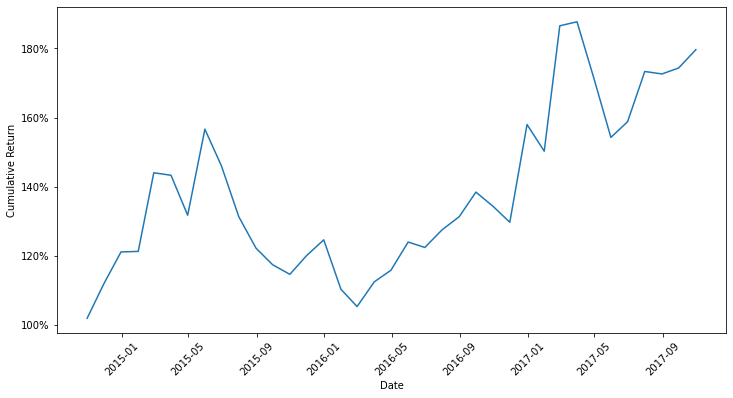

In [70]:
port.plot()

In [56]:
# New
class FactorModel2:
    def __init__(self, lookahead, lookback, regress_weighting):
        
        """
        lookahead: number of periods in the future to estimate
        lookback: number of periods in the past to use for estimations
        regress_weighting: array of size 4 with weight corresponding to each regression type; adds up to 1; 
        order is linear, lasso, ridge, SVR; in the case where there is one 1 and the rest 0's, there is no ensembling;
        can artifically call LSTM by setting all weights to 0
        """
        self.lookahead = lookahead
        self.lookback = lookback
        self.regress_weighting = regress_weighting
        return
               
    def get_param_estimate(self, rebal_date, data):
               
        if sum(self.regress_weighting) == 0:
            return self.get_mu_LSTM(rebal_date, data)

        elif sum(self.regress_weighting) == 1:
            return self.get_mu_Q_regression(rebal_date, data)
        
        else:
            return "ERROR: This regression weighting is not valid. Please make sure the weights sum to 1. You can also give all zeros for LSTM."
        
    def get_mu_Q_regression(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting
                
        # For keeping track of mu's and Q's from each period
        mu_arr = []
        Q_arr = []

        n_factors = len(factor_data.columns)

        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)
        
        for i in range(0, lookahead):

            # Calculate the factor covariance matrix
            F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()

            # Calculate the factor expected excess return from historical data using the geometric mean
            factor_data['Ones'] = [1 for i in range(len(factor_data))]
            gmean = stats.gmean(factor_data + 1,axis=0) - 1

            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()

            
            ### LINEAR REGRESSION
        
            model = LinearRegression().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_linear = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_linear = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### LASSO REGRESSION

            model = Lasso().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_lasso = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_lasso = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### RIDGE REGRESSION

            model = Ridge().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_ridge = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_ridge = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### SUPPORT VECTOR REGRESSION

            model = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)
            beta = np.array([[model.named_steps['multioutputregressor'].estimators_[i].coef_[0:n_factors] for i in range(len(model.named_steps['multioutputregressor'].estimators_))]])[0]
            alpha = np.array([model.named_steps['multioutputregressor'].estimators_[i].intercept_[0] for i in range(len(model.named_steps['multioutputregressor'].estimators_))])

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_SVR = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_SVR = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

        
            # Ensemble the methods
            mu = regress_weighting[0]*mu_linear + regress_weighting[1]*mu_lasso + regress_weighting[2]*mu_ridge + regress_weighting[3]*mu_SVR
            Q = regress_weighting[0]*Q_linear + regress_weighting[1]*Q_lasso + regress_weighting[2]*Q_ridge + regress_weighting[3]*Q_SVR

            # Add mu and Q to array
            mu_arr.append(mu)
            Q_arr.append(Q)

            # Update for next time step
            factor_data = factor_data[1:]
            factor_append = pd.Series(gmean, index = factor_data.columns)
            factor_data = factor_data.append(factor_append, ignore_index=True)

            returns_data = returns_data[1:]
            mu_append = pd.Series(mu, index=returns_data.columns)
            returns_data = returns_data.append(mu_append, ignore_index=True)   

        return mu_arr, Q_arr
        
    def get_mu_LSTM(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting

        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)
        
        tempx, tempy = self.generate_X_y(factor_data.values, returns_data.values, lookback, lookahead)
        train_x, test_x, train_y, test_y = self.traintest_split(tempx, tempy)

        # scale inputs
        scaled_train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())
        scaled_test_x = (test_x - test_x.min())/(test_x.max() - test_x.min())
        scaled_train_y = (train_y - train_y.min())/(train_y.max() - train_y.min())
        scaled_test_y = (test_y - test_y.min())/(test_y.max() - test_y.min())

        mu = self.get_prediction(train_x, train_y, factor_data, lookback)
        return mu
    
    def generate_X_y(self, factor_data, returns_data, n_lookback, n_lookforward):
        X, y = list(), list()
        in_start = 0
        for i in range(len(factor_data)):
            in_end = in_start + n_lookback
            out_end = in_end + n_lookforward
            # ensure we have enough data for this instance
            if out_end <= len(factor_data):
                X.append(factor_data[in_start:in_end,:])
                y.append(returns_data[in_end:out_end,:])
            in_start += 1
        return np.array(X), np.array(y)
    
    def traintest_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test   
    
    def build_model(self, train_x, train_y):
        # define parameters
        verbose, epochs, batch_size = 0, 50, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # define model
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(train_y.shape[2])))
        model.compile(loss='mse', optimizer='adam')
        # fit network
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model
    
    def forecast(self, model, history, n_lookback):
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for lookback data
        input_x = data[-n_lookback:, :]
        # reshape into [1, n_lookback, n]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        # forecast the next set
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def evaluate_forecasts(self, actual, predicted):
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                for k in range(actual.shape[2]):
                    s += (actual[row, col, k] - predicted[row, col, k])**2
        score = sqrt(s / (actual.shape[0] * actual.shape[1] * actual.shape[2]))
        return score

    def evaluate_model(self, train_x, train_y, test_x, test_y, n_lookback):
        # fit model
        model = self.build_model(train_x, train_y)
        history = [x for x in train_x]
        # walk-forward validation 
        predictions = list()
        for i in range(len(test_x)):
            yhat_sequence = self.forecast(model, history, n_lookback)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next set
            history.append(test_x[i, :])
        # evaluate predictions 
        predictions = np.array(predictions)
        score = self.evaluate_forecasts(test_y, predictions)
        plt.plot(model.history.history['loss'])
        #plt.plot(model.history.history['val_loss'])
        return score
    
    def get_prediction(self, train_x, train_y, factor_data, lookback):
        model = self.build_model(train_x, train_y)
        return self.forecast(model, factor_data.tail(lookback), lookback)


In [104]:
# Old
class FactorModel:
    def __init__(self, data, lookahead, lookback, model_type="Linear"):
        self.returns_data = data.stock_returns
        self.factor_data = data.factor_returns
        self.lookahead = lookahead
        self.lookback = lookback
        self.model_type = model_type
        return
               
    def get_param_estimate(self):
               
        if self.model_type == "LSTM":
            return self.get_mu_LSTM()

        elif self.model_type == "Linear" or self.model_type == "Lasso" or self.model_type == "Ridge" or self.model_type == "SVR":
            return self.get_mu_Q_regression()
        
        else:
            return "ERROR: This factor model type has not been implemented. Please input one of the following: LSTM, Linear, Lasso, Ridge, SVR."
        
    def get_mu_Q_regression(self): 
        returns_data = self.returns_data
        factor_data = self.factor_data
        lookahead = self.lookahead
        lookback = self.lookback
        regress_type = self.model_type
        
        # For keeping track of mu's and Q's from each period
        mu_arr = []
        Q_arr = []

        n_factors = len(factor_data.columns)
        factor_data = factor_data.tail(lookback)
        returns_data = returns_data.tail(lookback)

        for i in range(0, lookahead):

            # Calculate the factor covariance matrix
            F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()

            # Calculate the factor expected excess return from historical data using the geometric mean
            factor_data['Ones'] = [1 for i in range(len(factor_data))]
            gmean = stats.gmean(factor_data + 1,axis=0) - 1

            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()

           # Determine alpha and beta
            if regress_type=="Linear":
                model = LinearRegression().fit(X,Y)
                alpha = model.intercept_
                beta = model.coef_[:,0:n_factors]
            elif regress_type=="Lasso":
                model = Lasso().fit(X,Y)
                alpha = model.intercept_
                beta = model.coef_[:,0:n_factors]
            elif regress_type=="Ridge":
                model = Ridge().fit(X,Y)
                alpha = model.intercept_
                beta = model.coef_[:,0:n_factors]
            elif regress_type=="SVR":           
                model = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)
                beta = np.array([[model.named_steps['multioutputregressor'].estimators_[i].coef_[0:n_factors] for i in range(len(model.named_steps['multioutputregressor'].estimators_))]])[0]
                alpha = np.array([model.named_steps['multioutputregressor'].estimators_[i].intercept_[0] for i in range(len(model.named_steps['multioutputregressor'].estimators_))])
      

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            p = 3
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - 1 - p)

            #  Calculate the asset expected excess returns
            mu = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

            # Add mu and Q to array
            mu_arr.append(mu)
            Q_arr.append(Q)

            # Update for next time step
            factor_data = factor_data[1:]
            factor_append = pd.Series(gmean, index = factor_data.columns)
            factor_data = factor_data.append(factor_append, ignore_index=True)

            returns_data = returns_data[1:]
            mu_append = pd.Series(mu, index=returns_data.columns)
            returns_data = returns_data.append(mu_append, ignore_index=True)   

        return mu_arr, Q_arr
        
    def get_mu_LSTM(self): 
        returns_data = self.returns_data
        factor_data = self.factor_data
        lookahead = self.lookahead
        lookback = self.lookback
        regress_type = self.model_type
        
        tempx, tempy = self.generate_X_y(factor_data.values, returns_data.values, lookback, lookahead)
        train_x, test_x, train_y, test_y = self.traintest_split(tempx, tempy)

        # scale inputs
        scaled_train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())
        scaled_test_x = (test_x - test_x.min())/(test_x.max() - test_x.min())
        scaled_train_y = (train_y - train_y.min())/(train_y.max() - train_y.min())
        scaled_test_y = (test_y - test_y.min())/(test_y.max() - test_y.min())

        mu = self.get_prediction(train_x, train_y, factor_data, lookback)
        return mu
    
    def generate_X_y(self, factor_data, returns_data, n_lookback, n_lookforward):
        X, y = list(), list()
        in_start = 0
        for i in range(len(factor_data)):
            in_end = in_start + n_lookback
            out_end = in_end + n_lookforward
            # ensure we have enough data for this instance
            if out_end <= len(factor_data):
                X.append(factor_data[in_start:in_end,:])
                y.append(returns_data[in_end:out_end,:])
            in_start += 1
        return np.array(X), np.array(y)
    
    def traintest_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test   
    
    def build_model(self, train_x, train_y):
        # define parameters
        verbose, epochs, batch_size = 0, 50, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # define model
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(train_y.shape[2])))
        model.compile(loss='mse', optimizer='adam')
        # fit network
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model
    
    def forecast(self, model, history, n_lookback):
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for lookback data
        input_x = data[-n_lookback:, :]
        # reshape into [1, n_lookback, n]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        # forecast the next set
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def evaluate_forecasts(self, actual, predicted):
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                for k in range(actual.shape[2]):
                    s += (actual[row, col, k] - predicted[row, col, k])**2
        score = sqrt(s / (actual.shape[0] * actual.shape[1] * actual.shape[2]))
        return score

    def evaluate_model(self, train_x, train_y, test_x, test_y, n_lookback):
        # fit model
        model = self.build_model(train_x, train_y)
        history = [x for x in train_x]
        # walk-forward validation 
        predictions = list()
        for i in range(len(test_x)):
            yhat_sequence = self.forecast(model, history, n_lookback)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next set
            history.append(test_x[i, :])
        # evaluate predictions 
        predictions = np.array(predictions)
        score = self.evaluate_forecasts(test_y, predictions)
        plt.plot(model.history.history['loss'])
        #plt.plot(model.history.history['val_loss'])
        return score
    
    def get_prediction(self, train_x, train_y, factor_data, lookback):
        model = self.build_model(train_x, train_y)
        return self.forecast(model, factor_data.tail(lookback), lookback)
    

        
        
        

In [ ]:
rebal_freq="M"
start_date= "2014-10-31"
end_date= "2017-11-01"
lookback=20
lookahead=5
lam=0.9
trans_coeff=0.2
holding_coeff=0.2

test = Backtest(rebal_freq, start_date, end_date, lookback, lookahead)
test.grid_search(price_data,[i for i in range(20)], trans_coeff, holding_coeff, lam)

In [99]:
a=data_set.stock_returns.index[0]
print(a)

2010-12-31 00:00:00


In [293]:
    
    class Regime:
        def __init__(self, data ,t):
            train_data=None
            train_dates=None
            self.get_train_data(data,t)
            
        def get_train_data(self, data, t):
            mkt_data = data.factor_returns["Mkt-RF"]+data_set.factor_returns["RF"]
            first_date="2019-01-01"
            mkt_returns=mkt_data[first_date:t]
            self.train_dates=mkt_returns.index
            
            mkt_returns=np.array(mkt_returns.values)
            mkt_prices = 100*(np.array([x+1 for x in mkt_returns]).cumprod())
            mkt_prices=np.expand_dims(mkt_prices,axis=1)
            self.train_data= mkt_prices
            
            
        def HMM (self, num_hs):
            model=hmm.GaussianHMM(n_components=num_hs)
            model.fit(self.train_data)
            return model
            

In [294]:
t="2019-12-31"
reg=Regime(data_set,t)
reg_model =reg.HMM(2)

In [295]:
reg_model.means_

array([[122.08735281],
       [113.57296098]])

In [296]:
out=reg_model.predict(reg.train_data)

In [297]:
test=np.array(list(map(bool,out)))

In [298]:
reg_model.means_

array([[122.08735281],
       [113.57296098]])

Text(0, 0.5, 'Cumulative Return')

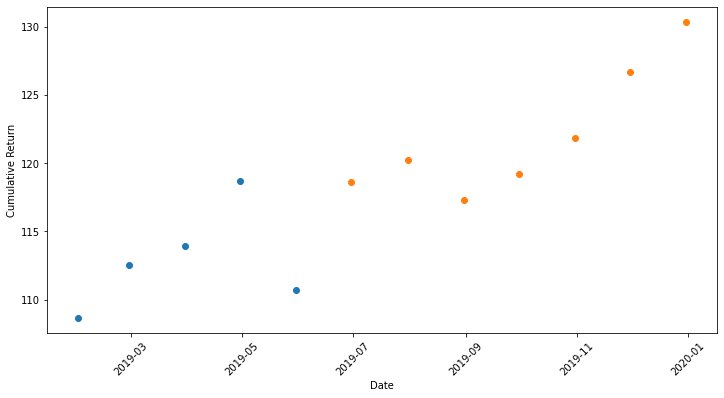

In [299]:


        plt.figure(figsize=(12,6))
        plt.scatter(reg.train_dates[test],reg.train_data[test])
        plt.scatter(reg.train_dates[~test],reg.train_data[~test])

        plt.xticks(rotation=45)
        #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        

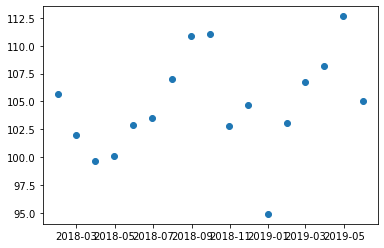

In [292]:
plt.scatter(reg.train_dates[~test],reg.train_data[~test])

In [281]:
reg.train_dates[test]

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31', '2008-11-30', '2008-12-31',
               '2009-01-31', '2009-02-28', '2009-03-31', '2009-04-30',
               '2009-05-31', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-31', '2009-11-30', '2009-12-31',
               '2010-01-31', '2010-02-28', '2010-03-31', '2010-04-30',
               '2010-05-31', '2010-06-30', '2010-07-31', '2010-08-31',
               '2010-09-30', '2010-10-31', '2010-11-30', '2010-12-31',
               '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
               '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
      